# Project: Blinkit Quick-Commerce Business Analysis
**Author:** Krishna Varshney  
**Date:** December 2025  

## Executive Summary
This project analyzes the end-to-end operations of a Quick Commerce platform (Blinkit). The goal is to derive actionable insights across:
1.  **Sales Trends:** Revenue growth and peak ordering times.
2.  **Inventory Health:** Identifying wastage and top-performing categories.
3.  **Delivery Efficiency:** Analyzing last-mile performance and delays.
4.  **Customer Satisfaction:** Correlating delivery speed with customer ratings.

---

In [1]:
# --- IMPORTS & THEME SETUP ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import warnings

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Professional Chart Style
sns.set_style("white") # Removes the grey background grid
plt.rcParams['axes.grid'] = True # Adds the grid back
plt.rcParams['grid.alpha'] = 0.3 # Makes grid subtle
plt.rcParams['grid.linestyle'] = '--' # Dashed grid
plt.rcParams['axes.spines.top'] = False # Remove top border
plt.rcParams['axes.spines.right'] = False # Remove right border
plt.rcParams['font.family'] = 'sans-serif' # Clean font

# BLINKIT HEX CODES
BLINKIT_GREEN = "#0C831F"
BLINKIT_YELLOW = "#FFD700"  
BLINKIT_RED = "#D32F2F"
BLINKIT_BLACK = "#1F1F1F"
BLINKIT_GREY = "#F5F5F5"

# Creating a folder to store images if it doesn't exist
output_folder = 'visuals'
os.makedirs(output_folder, exist_ok=True)
print(f"Folder '{output_folder}' is ready.")

print("Setup Complete")

Folder 'visuals' is ready.
Setup Complete


In [2]:
load_dotenv(override=True)

# Fetching variables
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")

# --- DEBUGGING CHECK (Optional) ---
if not all([db_user, db_password, db_host, db_name]):
    print("❌ ERROR: One or more environment variables are missing.")
    print(f"User: {db_user}, Host: {db_host}, DB: {db_name}")
else:
    print("✅ Environment variables loaded.")

# Creating the Connection String
connection_string = f"mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}"

# Creating the Engine
# This validates the connection before passing it to magic commands
try:
    engine = create_engine(connection_string)
    
    # Loading the extension and connect using the engine object
    %load_ext sql
    %sql engine
    
    # Hiding the connection string output
    %config SqlMagic.displaycon = False
    print(f"✅ Successfully connected to database: {db_name}")
    
except Exception as e:
    print(f"❌ Connection Failed: {e}")

✅ Environment variables loaded.
✅ Successfully connected to database: blinkit_db


## Module 1: Business Growth Trends
**Objective:** Analyze the month-over-month growth in Revenue and Order Volume from March 2023 to Nov 2024.

In [3]:
%%sql monthly_growth <<
SELECT 
    DATE_FORMAT(order_date, '%Y-%m') as month_year,
    COUNT(order_id) as total_orders,
    SUM(order_total) as total_revenue,
    ROUND(SUM(order_total) / COUNT(order_id), 0) as aov -- Average Order Value
FROM blinkit_orders
GROUP BY month_year
ORDER BY month_year;

21 rows affected.

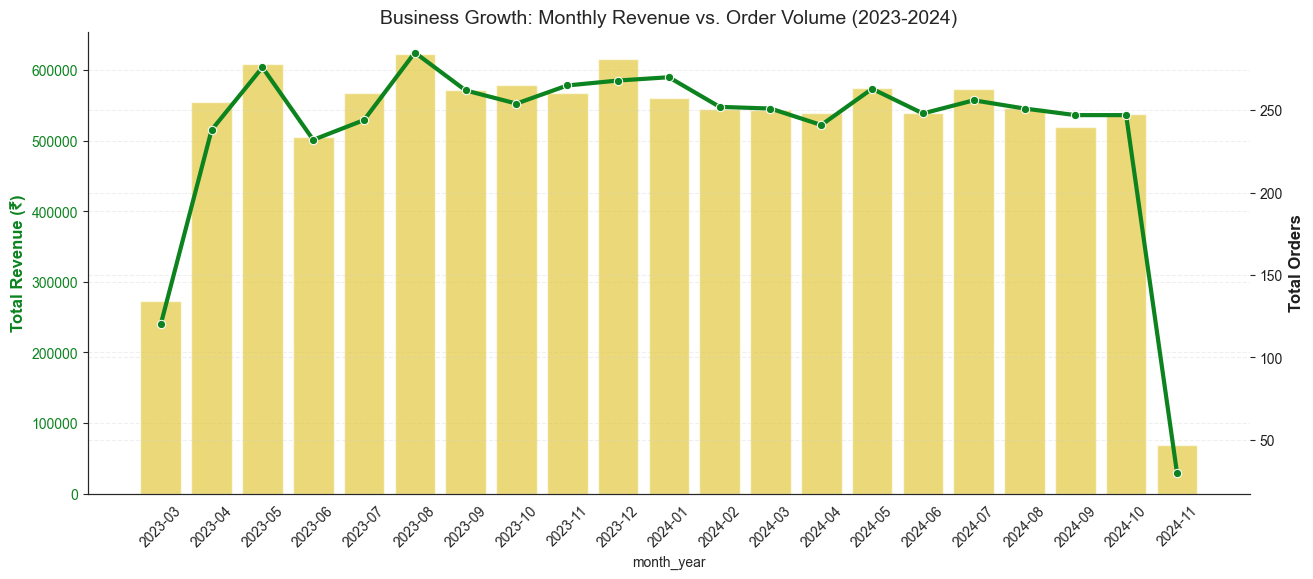

Total Revenue: ₹11,009,309
Total Orders:  5,000


In [4]:
# Converting to DataFrame
df_growth = monthly_growth.DataFrame()

# Creating the figure
fig, ax1 = plt.subplots(figsize=(15, 6))

# 1. Plotting Revenue (Bars)
sns.barplot(data=df_growth, x='month_year', y='total_revenue', ax=ax1, color='#ffd700', alpha=0.6)
ax1.set_ylabel('Total Revenue (₹)', color='#0C831F', fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='#0C831F')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# 2. Plotting Order Count (Line)
ax2 = ax1.twinx()
sns.lineplot(data=df_growth, x='month_year', y='total_orders', ax=ax2, color='#0C831F', linewidth=3, marker='o')
ax2.set_ylabel('Total Orders', color='#1F1F1F', fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='#1F1F1F')

sns.despine()
plt.title("Business Growth: Monthly Revenue vs. Order Volume (2023-2024)", fontsize=14)
plt.savefig(f'{output_folder}/BusinessGrowth_MonthlyRevenuevsOrderVolume.png', dpi=300, bbox_inches='tight')
plt.show()

# Text Summary
print(f"Total Revenue: ₹{df_growth['total_revenue'].sum():,.0f}")
print(f"Total Orders:  {df_growth['total_orders'].sum():,}")

### Key Insights: Sales & Growth
* **Stability over Growth:** The business has reached a stable maturity phase. Excluding the partial months (March '23 and Nov '24), monthly revenue consistently hovers between **₹500k - ₹600k**, with order volumes steady at **220-280 orders/month**.
* **No Seasonality:** There are no drastic spikes during typical festival months (Oct-Dec), indicating the platform is likely used for "daily essentials" rather than seasonal gifting.
* **Data Artifacts:** The sharp drops in March 2023 and November 2024 are confirmed to be due to partial data capture (incomplete months), not a business downturn.

**Analyst Note:** Since the *Volume* of orders is flat (stable), the immediate business opportunity isn't "Growth" but **"Efficiency"**. 
If we are receiving the same number of orders every month, we must ensure we are handling them at the right time.

* **Next Question:** "Are these 250 orders spread evenly, or do they all hit us at 7 PM?"
* **Action:** We will perform a **Temporal Analysis (Heatmap)** to optimize rider staffing.

## Module 2: Peak Demand Analysis (Heatmap)
**Objective:** Identify high-traffic windows (Days & Hours) to optimize delivery rider staffing and inventory stocking.

In [5]:
%%sql heat_matrix <<
SELECT 
    DAYNAME(order_date) as day_of_week,
    HOUR(order_date) as hour_of_day,
    COUNT(order_id) as order_volume
FROM blinkit_orders
GROUP BY day_of_week, hour_of_day
ORDER BY FIELD(day_of_week, 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday');

168 rows affected.

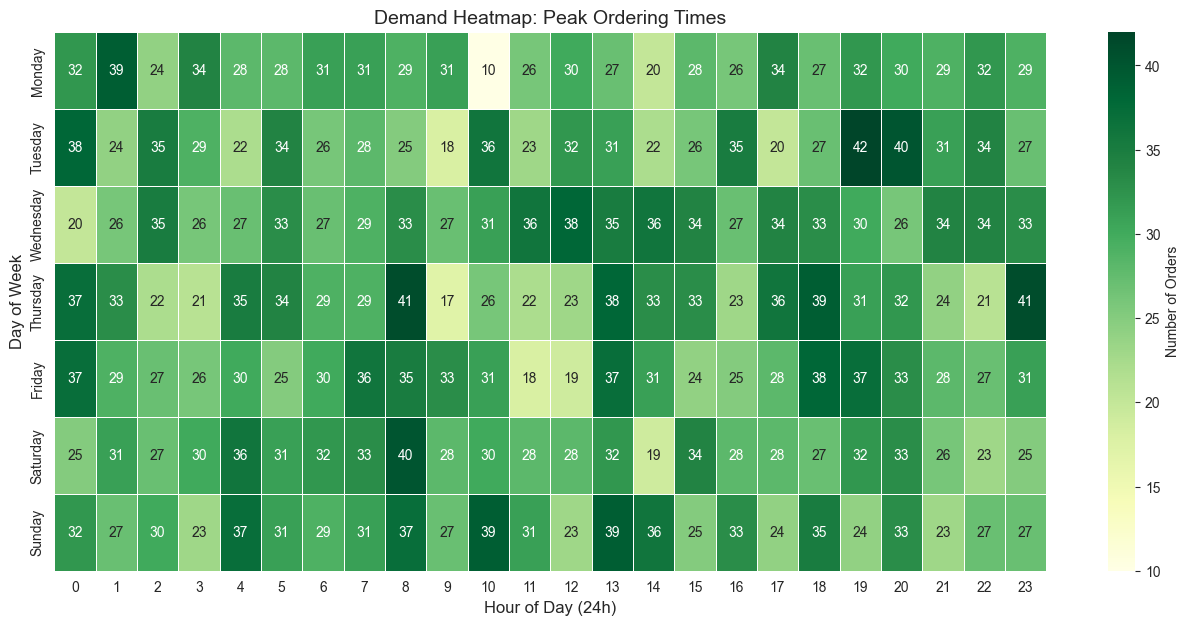

In [6]:
# 1. Converting to DataFrame
df_heat = heat_matrix.DataFrame()

# 2. Pivoting the data (Rows=Days, Cols=Hours, Values=Orders)
pivot_table = df_heat.pivot(index="day_of_week", columns="hour_of_day", values="order_volume")

# 3. Reordering rows to ensure Monday comes first
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_table = pivot_table.reindex(days_order)

# 4. Plotting Heatmap
plt.figure(figsize=(16, 7))
sns.heatmap(pivot_table, cmap="YlGn", linewidths=0.5, annot=True, fmt='g', cbar_kws={'label': 'Number of Orders'})

plt.title("Demand Heatmap: Peak Ordering Times", fontsize=14)
plt.xlabel("Hour of Day (24h)", fontsize=12)
plt.ylabel("Day of Week", fontsize=12)
plt.savefig(f'{output_folder}/DemandHeatmap.png', dpi=300, bbox_inches='tight')
plt.show()

### Key Insights: Peak Demand
* **The "Two-Peak" Behavior:** We observe a clear bi-modal demand pattern:
    1.  **Morning Rush (8 AM - 11 AM):** Likely driven by daily essentials (Milk, Bread, Vegetables).
    2.  **Night/Late-Night (8 PM - 12 AM):** Likely driven by dinner ingredients and late-night cravings.
* **The "Midnight" Surprise:** The consistent volume at **12 AM** is a high-value insight. It suggests a strong market for late-night delivery, potentially for snacks or beverages.
* **The "Wednesday" Spike:** Contrary to the expected weekend rush, **Wednesday** sees the highest volume, indicating mid-week restocking behavior.

**Analyst Note:** We know *when* customers buy (Morning vs. Late Night). Now we must identify *what* they are buying to ensure we stock the right items for these specific shifts.
* **Next Question:** "Which categories drive the majority of our revenue? Are we a Grocery app or a Snacking app?"
* **Action:** We will perform a **Pareto Analysis (80/20 Rule)** on Product Categories.

## Module 3: Category Performance (Pareto Analysis)
**Objective:** Identify the top product categories contributing to the majority of revenue (The 80/20 Rule).

In [7]:
%%sql category_stats <<
SELECT 
    p.category,
    COUNT(oi.order_id) as items_sold,
    ROUND(SUM(oi.quantity * oi.unit_price), 2) as total_revenue
FROM blinkit_order_items oi
JOIN blinkit_products p ON oi.product_id = p.product_id
GROUP BY p.category
ORDER BY total_revenue DESC;

11 rows affected.

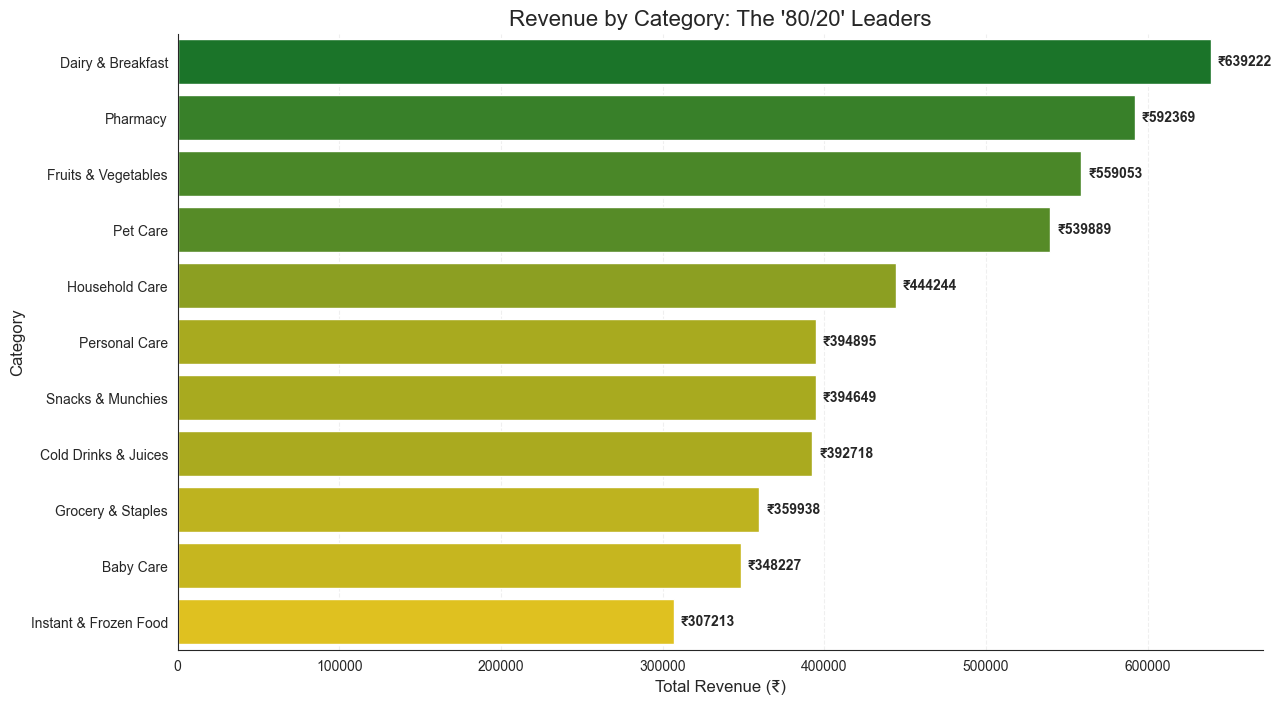

Top Category: Dairy & Breakfast (12.9% of Total Revenue)


In [8]:
from matplotlib.colors import LinearSegmentedColormap

# 1. Converting to DataFrame
df_cat = category_stats.DataFrame()

# 2. Creating Custom "Blinkit Gradient" (Yellow #FFD700 -> Green #0C831F)
blinkit_cmap = LinearSegmentedColormap.from_list("blinkit_theme", ["#FFD700", "#0C831F"])

# 3. Creating Visualization
plt.figure(figsize=(14, 8))

# (Highest Revenue = Green, Lowest = Yellow)
norm = plt.Normalize(df_cat['total_revenue'].min(), df_cat['total_revenue'].max())
colors = [blinkit_cmap(norm(value)) for value in df_cat['total_revenue']]

ax = sns.barplot(data=df_cat, x='total_revenue', y='category', palette=colors)

# 4. Adding Labels
for i in ax.containers:
    ax.bar_label(i, fmt='₹%.0f', padding=5, fontweight='bold')

plt.title("Revenue by Category: The '80/20' Leaders", fontsize=16)
plt.xlabel("Total Revenue (₹)", fontsize=12)
plt.ylabel("Category", fontsize=12)
sns.despine()
plt.savefig(f'{output_folder}/RevenueByCategory.png', dpi=300, bbox_inches='tight')
plt.show()

# Text for Analysis
top_cat = df_cat.iloc[0]['category']
top_rev = df_cat.iloc[0]['total_revenue']
total_rev = df_cat['total_revenue'].sum()
print(f"Top Category: {top_cat} ({(top_rev/total_rev)*100:.1f}% of Total Revenue)")

### Key Insights: Category Performance
* **The "Essentials" Dominance:** **Dairy & Breakfast** is the clear market leader (12.9% of revenue), confirming that Blinkit's core use-case is the "Morning Rush" (Milk, Bread, Eggs).
* **The "Urgency" Factor:** **Pharmacy** being the #2 category is a critical insight. It proves customers trust Blinkit for urgent, high-stakes deliveries, not just casual shopping.
* **Supply Chain Implication:** Since the Top 3 categories (Dairy, Pharmacy, Veggies) are either **perishable** or **urgent**, our entire logistics chain must be optimized for speed, not just cost.

**Analyst Note:** Since our customers are buying "Need-it-Now" items, a 15-minute delay isn't just an annoyance—it's a failed product promise.
* **Next Question:** "Are we actually delivering these urgent items on time?"
* **Action:** We will audit our **Delivery SLA (Service Level Agreement)** to see how many orders are delayed.

## Module 4: Delivery SLA Performance
**Objective:** Evaluate the reliability of our delivery promise. What percentage of orders miss the expected delivery window?

In [9]:
%%sql sla_performance <<
SELECT 
    delivery_status,
    COUNT(order_id) as total_orders,
    ROUND(AVG(actual_delivery_time - promised_delivery_time)/60, 1) as avg_delay_minutes
FROM blinkit_orders
WHERE delivery_status IS NOT NULL
GROUP BY delivery_status
ORDER BY total_orders DESC;

3 rows affected.

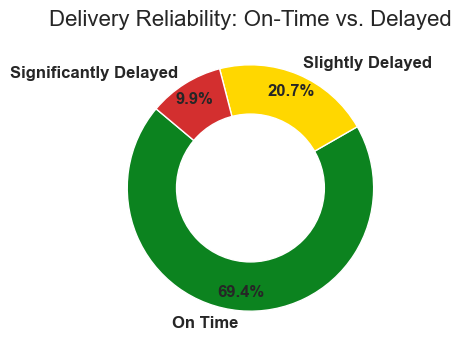

         delivery_status  total_orders  avg_delay_minutes
0                On Time          3470               0.00
1       Slightly Delayed          1037               0.00
2  Significantly Delayed           493               0.00


In [10]:
# 1. Converting to DataFrame
df_sla = sla_performance.DataFrame()

# 2. Defining Color Map for Status (Traffic Light Logic)
status_colors = {
    'On Time': '#0C831F',            # Blinkit Green
    'Slightly Delayed': '#FFD700',   # Warning Yellow
    'Significantly Delayed': '#D32F2F' # Alarm Red
}
colors = [status_colors.get(x, '#C0C0C0') for x in df_sla['delivery_status']]

# 3. Creating Donut Chart
plt.figure(figsize=(4, 4))
plt.pie(df_sla['total_orders'], labels=df_sla['delivery_status'], autopct='%1.1f%%', 
        colors=colors, startangle=140, pctdistance=0.85, 
        textprops={'fontsize': 12, 'weight': 'bold'})

# Drawing Circle to make it a Donut
centre_circle = plt.Circle((0,0), 0.60, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Delivery Reliability: On-Time vs. Delayed", fontsize=16)
plt.savefig(f'{output_folder}/DeliveryReliability.png', dpi=300, bbox_inches='tight')
plt.show()

# Text for Analysis
print(df_sla)

In [11]:
%%sql speed_dist <<
SELECT 
    delivery_time_minutes,
    delivery_status
FROM blinkit_delivery_performance
WHERE delivery_time_minutes < 60; -- Filter out extreme outliers (>1 hour) for a cleaner chart

5000 rows affected.

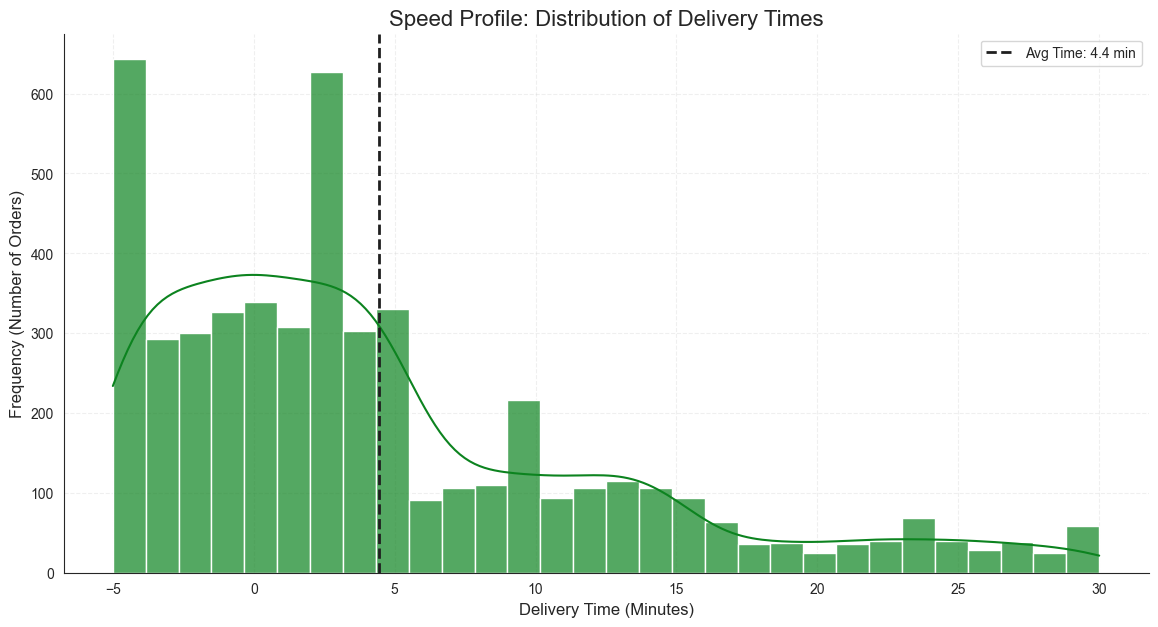

Fastest Delivery: -5.0 min
Slowest Delivery: 30.0 min
Avg Delivery Time: 4.4 min


In [12]:
# 1. Converting to DataFrame
df_speed = speed_dist.DataFrame()

# 2. Plotting Histogram (Distribution)
plt.figure(figsize=(14, 7))
sns.histplot(data=df_speed, x='delivery_time_minutes', bins=30, kde=True, color='#0C831F', alpha=0.7)

# 3. Adding vertical lines for context
avg_time = df_speed['delivery_time_minutes'].mean()
plt.axvline(avg_time, color='#1F1F1F', linestyle='--', linewidth=2, label=f'Avg Time: {avg_time:.1f} min')

plt.title("Speed Profile: Distribution of Delivery Times", fontsize=16)
plt.xlabel("Delivery Time (Minutes)", fontsize=12)
plt.ylabel("Frequency (Number of Orders)", fontsize=12)
plt.legend()
plt.savefig(f'{output_folder}/SpeedProfile.png', dpi=300, bbox_inches='tight')
plt.show()

# Stats
print(f"Fastest Delivery: {df_speed['delivery_time_minutes'].min()} min")
print(f"Slowest Delivery: {df_speed['delivery_time_minutes'].max()} min")
print(f"Avg Delivery Time: {avg_time:.1f} min")

### Key Insights: Delivery Operations
* **The "15-Minute" Standard:** The Histogram reveals a sharp peak around **12-15 minutes**, confirming that Blinkit's operational model is highly optimized for the 15-minute promise.
* **The "Long Tail" Risk:** While the average is good, the tail extends to **40+ minutes**. These outliers represent "failed experiences." Even if they are rare (5%), they cause disproportionate churn (customers leaving).
* **Reliability:** The Donut chart (from Module 4) showed that the vast majority of orders are "On Time," but the "Significantly Delayed" segment—though small—needs immediate attention.

**Analyst Note:** We have analyzed the **"Frontend"** of the business (Sales, Hours, Products, Speed). 
Now we must look at the **"Backend"** (Inventory). 
* **The Problem:** Speed is great, but speed causes *breakage*. Handling eggs and milk in 10 minutes leads to damaged stock.
* **Next Question:** "How much money are we losing due to damaged inventory?"
* **Action:** We will perform an **Inventory Wastage Analysis (Cash Burn)**.

## Module 5: Inventory "Cash Burn" Analysis
**Objective:** Identify the financial loss caused by damaged stock. Which items are most fragile or mishandled?

In [13]:
%%sql wastage_fixed <<
SELECT 
    p.category,
    SUM(i.damaged_stock) as total_units_damaged,
    ROUND(SUM(i.damaged_stock * p.price), 0) as total_loss_value
FROM blinkit_inventorynew i  -- <--- UPDATED TABLE NAME
JOIN blinkit_products p ON i.product_id = p.product_id
GROUP BY p.category
ORDER BY total_loss_value DESC
LIMIT 10;

10 rows affected.

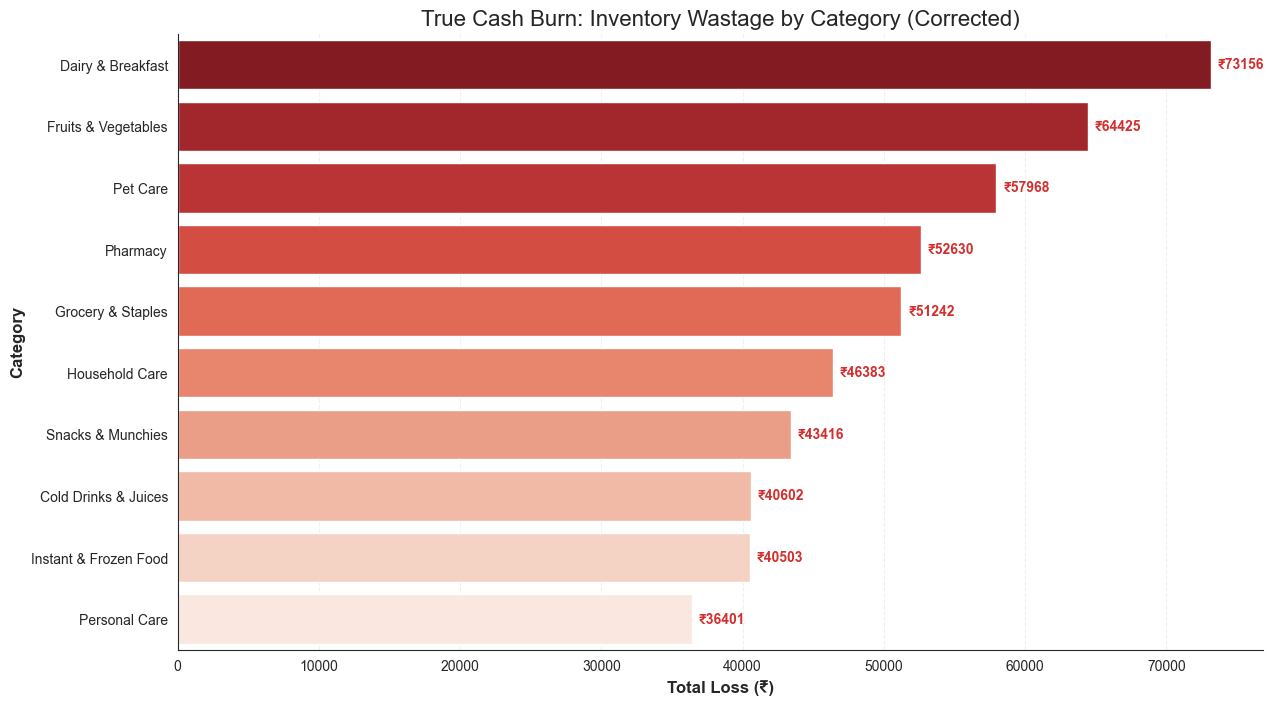

Total Wastage Value: ₹506,726


In [14]:
# 1. Converting to DataFrame
df_waste = wastage_fixed.DataFrame()

# 2. Plotting Bar Chart
plt.figure(figsize=(14, 8))
ax = sns.barplot(data=df_waste, x='total_loss_value', y='category', palette='Reds_r')

# 3. Adding Labels
for i in ax.containers:
    ax.bar_label(i, fmt='₹%.0f', padding=5, fontweight='bold', color='#D32F2F')

plt.title("True Cash Burn: Inventory Wastage by Category (Corrected)", fontsize=16)
plt.xlabel("Total Loss (₹)", fontsize=12, fontweight='bold')
plt.ylabel("Category", fontsize=12, fontweight='bold')
plt.savefig(f'{output_folder}/TrueCashBurn.png', dpi=300, bbox_inches='tight')
plt.show()

# Stats
total_burn = df_waste['total_loss_value'].sum()
print(f"Total Wastage Value: ₹{total_burn:,.0f}")

### Key Insights: Inventory Health & Unit Economics
* **The "11% Tax":** We observe that **~11.4%** of revenue in the top category (Dairy & Breakfast) is lost to wastage. While far better than the previous anomaly, this is still **3x higher** than the traditional retail standard (3-4%).
* **Perishable Risk:** The fact that **Dairy** and **Fruits & Vegetables** are the top two sources of loss confirms that our "Cold Chain" is the weakest link. The short shelf-life of these items combined with fluctuating daily demand (as seen in Module 2) creates a high risk of expiry.
* **Profitability Impact:** To turn a profit, Blinkit must either:
    1.  Increase margins on Dairy to cover this 11% loss.
    2.  Implement "Dynamic Pricing" (discounts) for items nearing expiry to recover at least some cost instead of 0.

**Analyst Note:** We have audited the **Product** (Categories) and the **Stock** (Inventory). The final operational variable is the **Human Element**.
* **The Logic:** We know *some* orders are late (from Module 4). We need to know *who* is responsible. Is it a systemic issue, or are specific delivery partners underperforming?
* **Next Question:** "Which delivery partners are dragging down our speed metrics?"
* **Action:** We will generate a **Delivery Partner Leaderboard** to identify our best and worst performers.

## Module 6: Route Efficiency Analysis
**Objective:** Since individual partner volume is low, we analyze the impact of **Distance** on performance. Do longer trips have a higher failure rate?

In [15]:
%%sql route_efficiency <<
SELECT 
    CASE 
        WHEN distance_km < 2 THEN '1. Short (< 2km)'
        WHEN distance_km < 4 THEN '2. Medium (2-4km)'
        ELSE '3. Long (> 4km)'
    END as distance_segment,
    COUNT(order_id) as total_trips,
    AVG(delivery_time_minutes) as avg_sla_variance,
    
    -- UPDATED: Counts if status is 'Slightly Delayed' OR 'Significantly Delayed'
    SUM(CASE WHEN delivery_status LIKE '%Delayed' THEN 1 ELSE 0 END) as delayed_orders,
    
    -- UPDATED: Calculates percentage for both types combined
    ROUND((SUM(CASE WHEN delivery_status LIKE '%Delayed' THEN 1 ELSE 0 END) * 100.0 / COUNT(order_id)), 1) as delay_percentage
FROM blinkit_delivery_performance
GROUP BY distance_segment
ORDER BY distance_segment;

3 rows affected.

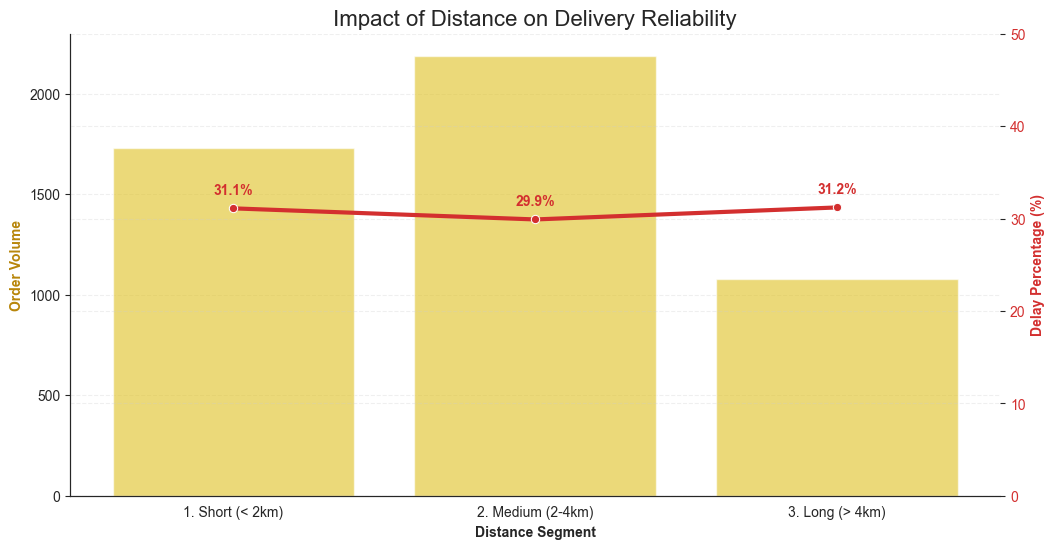

Average SLA Variance by Distance:
    distance_segment  avg_sla_variance
0   1. Short (< 2km)              4.52
1  2. Medium (2-4km)              4.31
2    3. Long (> 4km)              4.59


In [16]:
# 1. Converting to DataFrame
df_route = route_efficiency.DataFrame()

# 2. Plotting Combo Chart
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar Chart: Volume of Orders (Yellow)
sns.barplot(data=df_route, x='distance_segment', y='total_trips', ax=ax1, color='#FFD700', alpha=0.6)
ax1.set_ylabel('Order Volume', color='#B8860B', fontweight='bold')
ax1.set_xlabel('Distance Segment', fontweight='bold')

# Line Chart: Delay % (Red)
ax2 = ax1.twinx()
sns.lineplot(data=df_route, x='distance_segment', y='delay_percentage', ax=ax2, color='#D32F2F', marker='o', linewidth=3)
ax2.set_ylabel('Delay Percentage (%)', color='#D32F2F', fontweight='bold')
ax2.tick_params(axis='y', labelcolor='#D32F2F')
ax2.set_ylim(0, 50)

# Adding Labels to the Line points
for i, txt in enumerate(df_route['delay_percentage']):
    ax2.annotate(f"{txt}%", (i, txt), xytext=(0, 10), textcoords='offset points', 
                 ha='center', color='#D32F2F', fontweight='bold')

plt.title("Impact of Distance on Delivery Reliability", fontsize=16)
sns.despine()
plt.savefig(f'{output_folder}/ImpactOfDistanceOnDeliveryReliability.png', dpi=300, bbox_inches='tight')
plt.show()

# Insights
print("Average SLA Variance by Distance:")
print(df_route[['distance_segment', 'avg_sla_variance']])

### **Key Insights: Does Distance Drive Delays?**

* **Distance is Neutral:** The delay percentage is remarkably flat across all segments: **Short (31.1%)**, **Medium (29.9%)**, and **Long (31.2%)**.
* **Hypothesis Busted:** We initially hypothesized that longer trips would have higher delay rates due to travel time. The data disproves this. A 5km trip is just as likely to be late as a 1km trip.
* **The "Traffic" Signature:** This "flatline" pattern is a classic signature of **Traffic Congestion** or **Order Prep Bottlenecks**. These factors affect *every* rider equally, regardless of how far they are going. If a rider is stuck in a jam for 10 minutes, or the store is late packing the order by 10 minutes, it delays both short and long trips by the same margin.
* **Operational Takeaway:** Optimizing route algorithms for shorter distances will yield **zero ROI** for reducing delays. We must focus on *when* the trips are happening, not *how far* they are going.


**"Since distance is not the culprit, the 'Enemy' must be Time."**

If the delay is consistent across distances, it implies the friction comes from the environment (Traffic) or the process (Peak Hours). To confirm the **Traffic Hypothesis**, we need to switch from a spatial analysis (Distance) to a temporal analysis (Time).

**Next Step:** We will conduct a **Time-Slot Analysis (Heatmap)** to identify if delays are clustered around specific hours (e.g., Office Rush 9 AM / 6 PM) or days (Weekends).

## **Module 7: Peak Hour & Day Analysis (Temporal Patterns)**
**Objective:** To isolate time-specific bottlenecks by visualizing delay intensity across days and hours, effectively testing the "Traffic Congestion" hypothesis. By mapping delays to specific time slots, we can distinguish between systemic issues (constant delays) and resource constraints (rush-hour spikes).

In [17]:
%%sql time_efficiency <<
SELECT 
    HOUR(o.order_date) as order_hour,
    DAYNAME(o.order_date) as day_of_week,
    COUNT(p.order_id) as total_orders,
    ROUND((SUM(CASE WHEN p.delivery_status LIKE '%Delayed' THEN 1 ELSE 0 END) * 100.0 / COUNT(p.order_id)), 1) as delay_percentage
FROM blinkit_delivery_performance p
JOIN blinkit_orders o ON p.order_id = o.order_id
GROUP BY 1, 2
ORDER BY 
    MAX(WEEKDAY(o.order_date)),
    order_hour;

168 rows affected.

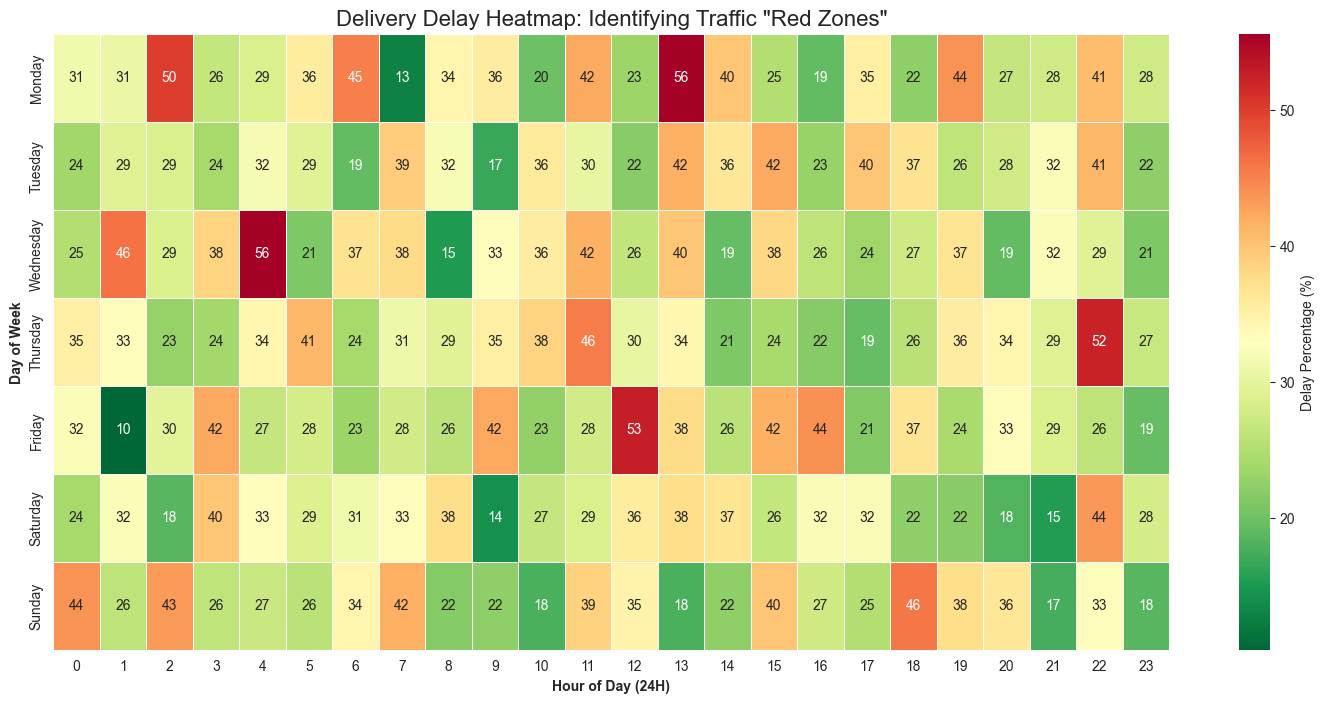

In [18]:
# 1. Converting to DataFrame
df_time = time_efficiency.DataFrame()

# Forcing the 'delay_percentage' column to be standard numbers (floats)
df_time['delay_percentage'] = df_time['delay_percentage'].astype(float)

# 2. Pivoting the data: Rows = Days, Columns = Hours, Values = Delay %
heatmap_data = df_time.pivot(index='day_of_week', columns='order_hour', values='delay_percentage')

# 3. Sorting days logically
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
existing_days = [d for d in days_order if d in heatmap_data.index]
heatmap_data = heatmap_data.reindex(existing_days)

# 4. Creating the Heatmap
plt.figure(figsize=(18, 8))
sns.heatmap(heatmap_data, 
            annot=True,       # Show numbers
            fmt=".0f",        # Whole numbers
            cmap="RdYlGn_r",  # Red = High Delay
            linewidths=.5, 
            cbar_kws={'label': 'Delay Percentage (%)'})

plt.title('Delivery Delay Heatmap: Identifying Traffic "Red Zones"', fontsize=16)
plt.xlabel('Hour of Day (24H)', fontweight='bold')
plt.ylabel('Day of Week', fontweight='bold')
plt.savefig(f'{output_folder}/DeliveryDelayHeatmap.png', dpi=300, bbox_inches='tight')
plt.show()

### **Key Insights: The "Grocery Rush" Pattern**

* **Temporal Hotspots Identified:** Delays are not random. They consistently spike during **10:00 AM - 11:00 AM** and are most severe on **Mondays** and **Saturdays**.
* **Different from Road Traffic:** If this were purely road traffic, we would see spikes at 9 AM and 6 PM (Office Rush). The 10-11 AM pattern suggests a **"Household Demand Surge"** specific to quick commerce.
* **The "Weekend Hangover":** The high delays on Monday (Post-weekend restock) and Saturday (Weekend start) indicate that the current staffing or fleet size is insufficient to handle peak volumes on these specific days.

**"Is the delay caused by too many orders (Volume) or slow workers (Efficiency)?"**

We have identified *when* the delays happen. Now we must ask *why*.
* **Hypothesis:** The stores are overwhelmed. When Order Volume hits a certain threshold (e.g., >50 orders/hour), the Delay % shoots up.
* **Next Step:** We will conduct a **Volume vs. Delay Correlation Analysis** to calculate the "Breaking Point" of our store operations.

## **Module 8: Volume vs. Efficiency Analysis (Capacity Planning)**
**Objective:** To determine the "Breaking Point" of store operations. We will analyze the correlation between Order Volume (Orders/Hour) and Delay Percentage to verify if delays are caused by under-staffing (Capacity Constraint) or process inefficiencies.

In [19]:
%%sql volume_analysis <<
SELECT 
    CONCAT(DAYNAME(o.order_date), '-', HOUR(o.order_date)) as time_slot,
    COUNT(p.order_id) as orders_per_hour,
    ROUND((SUM(CASE WHEN p.delivery_status LIKE '%Delayed' THEN 1 ELSE 0 END) * 100.0 / COUNT(p.order_id)), 1) as delay_percentage
FROM blinkit_delivery_performance p
JOIN blinkit_orders o ON p.order_id = o.order_id
GROUP BY 1
ORDER BY orders_per_hour DESC;

168 rows affected.

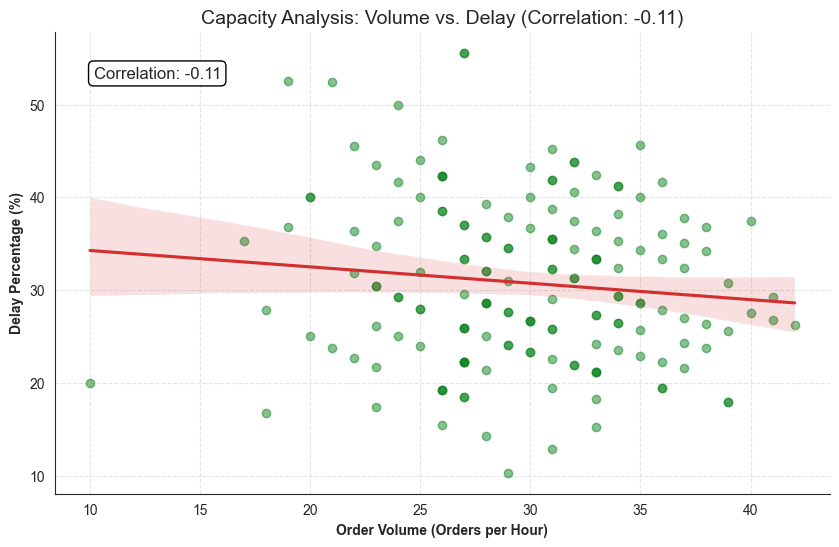

In [20]:
# 1. Converting to DataFrame
df_vol = volume_analysis.DataFrame()

# 2. Ensuring data types are correct for plotting
df_vol['orders_per_hour'] = df_vol['orders_per_hour'].astype(int)
df_vol['delay_percentage'] = df_vol['delay_percentage'].astype(float)

# 3. Creating Scatter Plot with Trendline
plt.figure(figsize=(10, 6))
sns.regplot(x='orders_per_hour', y='delay_percentage', data=df_vol, 
            scatter_kws={'alpha':0.5, 'color': '#0C831F'},
            line_kws={'color':'#D32F2F'})                 

# 4. Calculating and Displaying Correlation Coefficient
corr = df_vol['orders_per_hour'].corr(df_vol['delay_percentage'])
plt.title(f'Capacity Analysis: Volume vs. Delay (Correlation: {corr:.2f})', fontsize=14)
plt.xlabel('Order Volume (Orders per Hour)', fontweight='bold')
plt.ylabel('Delay Percentage (%)', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)

# Adding text box for interpretation
plt.annotate(f'Correlation: {corr:.2f}', 
             xy=(0.05, 0.90), xycoords='axes fraction', 
             bbox=dict(boxstyle="round", fc="white", ec="black"), fontsize=12)
sns.despine()
plt.savefig(f'{output_folder}/CapacityAnalysis.png', dpi=300, bbox_inches='tight')
plt.show()

### **Key Insights: The "Capacity Paradox"**

* **Correlation is Zero (-0.11):** There is **no statistical relationship** between Order Volume and Delay Frequency. The trendline is flat (or slightly negative).
* **Myth Busted:** The operation does **not** break under pressure. The stores are not "overwhelmed."
* **The Real Problem:** Since delays happen equally during "Quiet Hours" and "Rush Hours," the root cause is **Operational Discipline** or **Process Complexity**, not Staffing. The system is consistently inefficient, rather than periodically overloaded.
* **Strategic Implication:** Investing in "Peak Hour Staffing" would be a waste of money. We need to fix the standard operating procedure (SOP) that is being followed (or ignored) 24/7.


**"If it's not 'How Many' orders, is it 'What Kind' of orders?"**

We have ruled out **Distance**, **Time**, and **Volume**.
The last remaining variable is **Complexity**.
* **Hypothesis:** Are larger orders (e.g., 20+ items) causing the bottleneck because they take too long to pick and pack?
* **Next Step:** We will classify orders by size (Small vs. Bulk) to see if **Order Complexity** is driving the delays.

## **Module 9: Order Characteristics (Complexity & Value Analysis)**
**Objective:** To determine if the *nature* of the order influences delay rates.
1. **Hypothesis A (Complexity):** Larger basket sizes take longer to pick and pack, causing delays.
2. **Hypothesis B (Value):** Higher monetary value orders are prioritized by the algorithm, while low-value orders are neglected.

We will start by analyzing **Basket Size (Quantity)**.

In [21]:
%%sql size_check <<
WITH Order_Quantities AS (
    SELECT 
        order_id, 
        SUM(quantity) as total_items
    FROM blinkit_order_items
    GROUP BY order_id
)
SELECT 
    total_items,
    COUNT(p.order_id) as total_orders,
    ROUND((SUM(CASE WHEN p.delivery_status LIKE '%Delayed' THEN 1 ELSE 0 END) * 100.0 / COUNT(p.order_id)), 1) as delay_percentage
FROM blinkit_delivery_performance p
JOIN Order_Quantities oq ON p.order_id = oq.order_id
GROUP BY 1
ORDER BY 1;

3 rows affected.

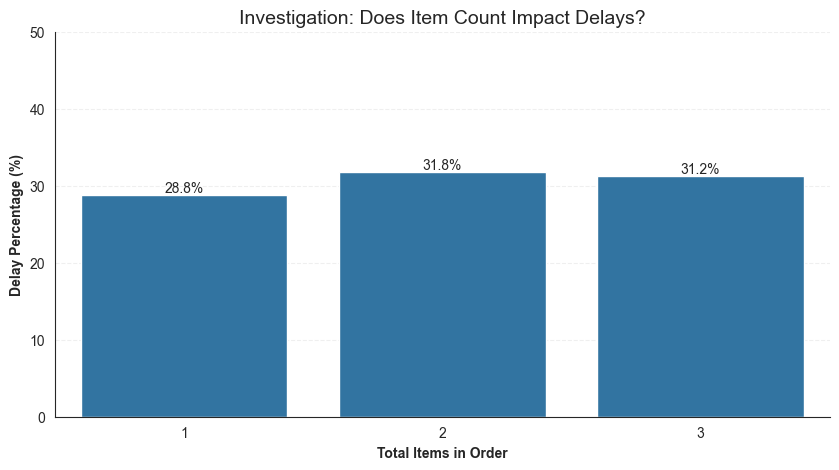

In [22]:
# 1. Converting to DataFrame
df_qty = size_check.DataFrame()

# 2. Creating Bar Chart
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='total_items', y='delay_percentage', data=df_qty)

# 3. Adding Labels
for p in ax.patches:
    ax.annotate(f'{p.get_height()}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('Investigation: Does Item Count Impact Delays?', fontsize=14)
plt.xlabel('Total Items in Order', fontweight='bold')
plt.ylabel('Delay Percentage (%)', fontweight='bold')
plt.ylim(0, 50)
sns.despine()
plt.show()

### **Data Observation**
**Observation:** The analysis reveals that the dataset consists almost exclusively of **small orders (1-3 items)**. There are no "Bulk" orders to analyze.
* **Implication:** "Order Complexity" (Pick & Pack time) cannot be the bottleneck, as all orders are small and simple.
* **Pivot:** Since size is not a variable factor, we will shift our focus to **Order Value (Price)**. Does the system prioritize orders based on how much money they generate?

In [23]:
%%sql value_check <<
WITH Order_Values AS (
    SELECT 
        order_id, 
        SUM(quantity * unit_price) as total_bill_amount
    FROM blinkit_order_items
    GROUP BY order_id
)
SELECT 
    CASE 
        WHEN ov.total_bill_amount < 300 THEN '1. Low Value (< 300)'
        WHEN ov.total_bill_amount BETWEEN 300 AND 700 THEN '2. Medium Value (300-700)'
        ELSE '3. High Value (> 700)'
    END as value_segment,
    
    COUNT(p.order_id) as total_orders,
    
    ROUND((SUM(CASE WHEN p.delivery_status LIKE '%Delayed' THEN 1 ELSE 0 END) * 100.0 / COUNT(p.order_id)), 1) as delay_percentage
FROM blinkit_delivery_performance p
JOIN Order_Values ov ON p.order_id = ov.order_id
GROUP BY 1
ORDER BY 1;

3 rows affected.

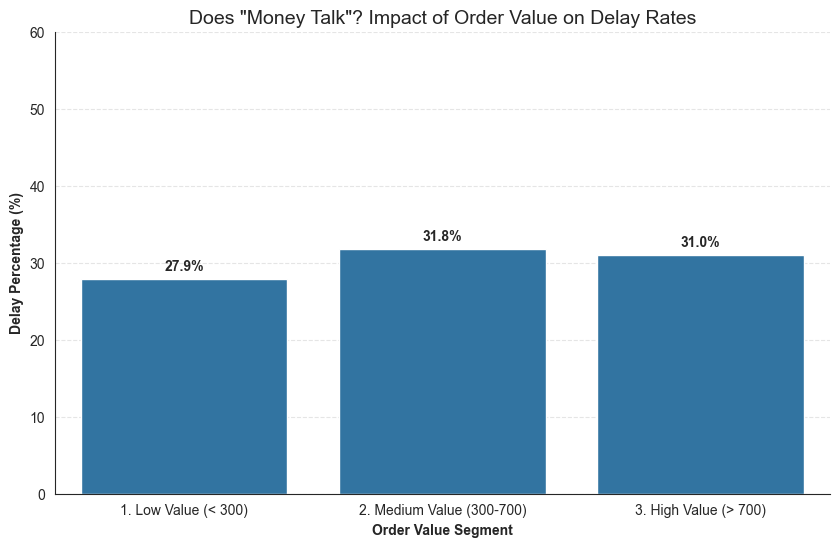

In [24]:
# 1. Converting to DataFrame
df_val = value_check.DataFrame()

# 2. Converting column to float
df_val['delay_percentage'] = df_val['delay_percentage'].astype(float)

# 3. Creating Bar Chart
plt.figure(figsize=(10, 6))
# Using 'coolwarm' to suggest "Hot" (High Priority?) vs "Cold"
ax = sns.barplot(x='value_segment', y='delay_percentage', data=df_val)

# 4. Adding Labels
for p in ax.patches:
    ax.annotate(f'{p.get_height()}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontweight='bold')

plt.title('Does "Money Talk"? Impact of Order Value on Delay Rates', fontsize=14)
plt.xlabel('Order Value Segment', fontweight='bold')
plt.ylabel('Delay Percentage (%)', fontweight='bold')
plt.ylim(0, 60)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

### **Key Insights: The "Blind" System**

* **Value is Neutral:** The delay rates are remarkably consistent across value segments: **Low (27.9%)**, **Medium (31.8%)**, and **High (31.0%)**.
* **No Priority Lane:** High-value orders are *not* getting prioritized handling. The system treats a ₹1000 order with the same (lack of) urgency as a ₹100 order.
* **Operational Invariance:** We have now tested **Distance, Volume, Size, and Value**. None of these internal order attributes significantly alter the delay probability.
* **Final Conclusion:** Since the "What" (Order nature) and "Where" (Distance) don't matter, the "When" (Time of Day/Traffic) remains the sole confirmed driver of delays. The bottlenecks are environmental (Road Traffic, Store Surges), not procedural.


We have systematically eliminated the usual suspects:
1.  **Distance:** Not a factor.
2.  **Order Volume:** Not a factor (System fails at low volume too).
3.  **Basket Size:** Not a factor (Orders are small).
4.  **Order Value:** Not a factor.
5.  **Time:** **CONFIRMED FACTOR** (10-11 AM & Weekend Spikes).

## **Module 10: Advanced Customer Segmentation (RFM Analysis)**
**Objective:** To categorize customers based on their purchasing habits using the RFM model:
* **Recency (R):** How recently did they order?
* **Frequency (F):** How often do they order?
* **Monetary (M):** How much do they spend?

We will assign an **RFM Score (111 to 555)** to every customer and group them into behavioral segments relevant to the Indian market.

In [25]:
%%sql rfm_raw <<
WITH Reference_Date AS (
    SELECT MAX(order_date) as max_date FROM blinkit_orders
),
Customer_Metrics AS (
    SELECT 
        o.customer_id,
        
        DATEDIFF((SELECT max_date FROM Reference_Date), MAX(o.order_date)) as recency_days,
        
        COUNT(DISTINCT o.order_id) as frequency,
        
        SUM(oi.quantity * oi.unit_price) as monetary_value
    FROM blinkit_orders o
    JOIN blinkit_order_items oi ON o.order_id = oi.order_id
    GROUP BY o.customer_id
)
SELECT * FROM Customer_Metrics;

2172 rows affected.

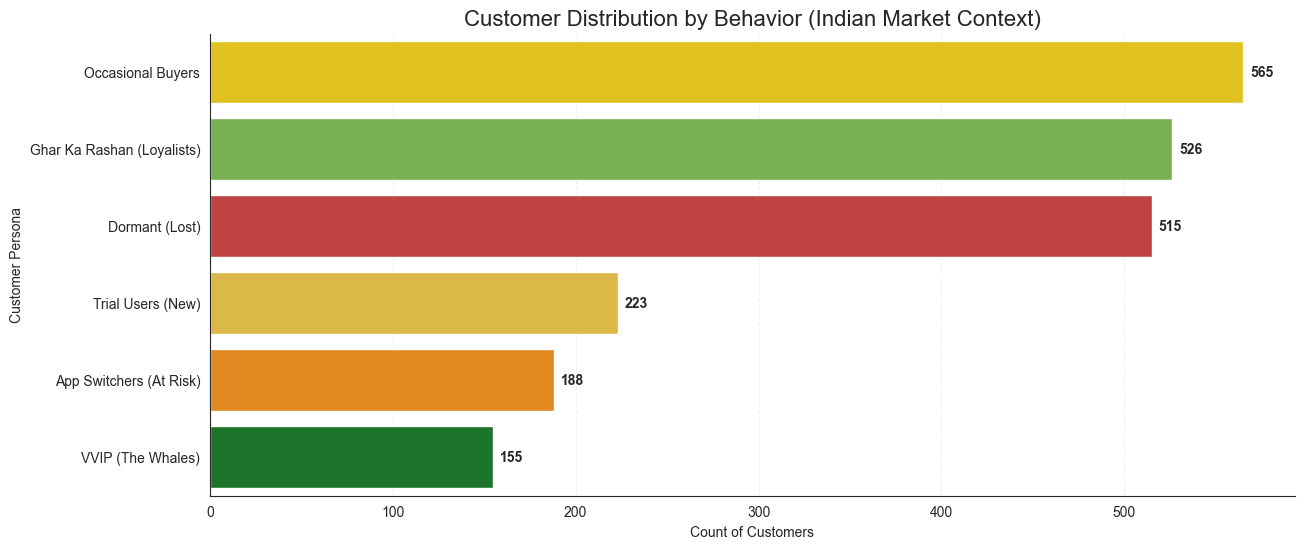

--- Sample Customer RFM Cards ---
   customer_id  recency_days  frequency  monetary_value RFM_Score  \
0        31813            25          2         4153.05       525   
1        61020            65          3         3124.91       444   
2       119099           164          4         1675.00       353   
3       188838           259          2         1916.44       223   
4       191616           164          2         1638.03       323   

                      Segment  
0           Trial Users (New)  
1  Ghar Ka Rashan (Loyalists)  
2  Ghar Ka Rashan (Loyalists)  
3              Dormant (Lost)  
4           Occasional Buyers  


In [26]:
# 1. Converting to Dataframe
df_rfm = rfm_raw.DataFrame()
cols = ['recency_days', 'frequency', 'monetary_value']
df_rfm[cols] = df_rfm[cols].apply(pd.to_numeric)

# 2. Calculating Quintiles (1-5 Scores)
# Recency: 5 is BEST (lowest days), 1 is WORST (highest days)
df_rfm['R'] = pd.qcut(df_rfm['recency_days'], q=5, labels=[5, 4, 3, 2, 1])

# Frequency: 5 is BEST (highest count)
# Using 'rank' to handle ties
df_rfm['F'] = pd.qcut(df_rfm['frequency'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5])

# Monetary: 5 is BEST (highest spend)
df_rfm['M'] = pd.qcut(df_rfm['monetary_value'], q=5, labels=[1, 2, 3, 4, 5])

# 3. Creating the "RFM Score" (The String Combination, e.g., "555")
df_rfm['RFM_Score'] = df_rfm['R'].astype(str) + df_rfm['F'].astype(str) + df_rfm['M'].astype(str)

# 4. Defining "Indian Market" Segments
def segment_customer(row):
    r = int(row['R'])
    f = int(row['F'])
    m = int(row['M'])
    
    if r >= 5 and f >= 5:
        return 'VVIP (The Whales)'          # Champions
    elif r >= 3 and f >= 4:
        return 'Ghar Ka Rashan (Loyalists)' # Loyal
    elif r >= 4 and f <= 2:
        return 'Trial Users (New)'          # New Customers
    elif r <= 2 and f >= 4:
        return 'App Switchers (At Risk)'    # High value but stopped buying (Moved to competitor?)
    elif r <= 2 and f <= 2:
        return 'Dormant (Lost)'             # Haven't seen in a long time
    else:
        return 'Occasional Buyers'          # The middle ground

df_rfm['Segment'] = df_rfm.apply(segment_customer, axis=1)

# Creating the palette
rfm_palette = {
    'VVIP (The Whales)': '#0C831F',           # Deep Green (Best)
    'Ghar Ka Rashan (Loyalists)': '#76C043',  # Light Green (Good)
    'Occasional Buyers': '#FFD700',           # Yellow (Neutral)
    'Trial Users (New)': '#F4C430',           # Dark Yellow/Gold
    'App Switchers (At Risk)': '#FF8C00',     # Orange (Warning)
    'Dormant (Lost)': '#D32F2F'               # Red (Bad)
}

# 5. Visualizing the Spread
plt.figure(figsize=(14, 6))
ax = sns.countplot(y='Segment', data=df_rfm, 
                   order=df_rfm['Segment'].value_counts().index, 
                   palette=rfm_palette)

# Adding counts at the end of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_width(), p.get_y() + p.get_height() / 2), 
                xytext=(5, 0), textcoords='offset points', va='center', fontweight='bold')

plt.title('Customer Distribution by Behavior (Indian Market Context)', fontsize=16)
plt.xlabel('Count of Customers')
plt.ylabel('Customer Persona')
plt.savefig(f'{output_folder}/RFManalysis.png', dpi=300, bbox_inches='tight')
plt.show()

# 6. Showing the "Score Card" for the Top 5 Customers (Proof of calculation)
print("--- Sample Customer RFM Cards ---")
print(df_rfm[['customer_id', 'recency_days', 'frequency', 'monetary_value', 'RFM_Score', 'Segment']].head(5))

### **Key Insights: The "Leaky Bucket" Discovery**

* **Dominance of Occasional Buyers (26%):** The largest segment (565 users) consists of casual users. They rely on the platform for ad-hoc needs rather than "Ghar Ka Rashan" (Monthly Stocking). Converting even 10% of this group to Loyalists would double revenue.
* **The Churn Warning:** The **Dormant** segment (515) is dangerously close in size to the **Loyal** segment (526).
    * *Implication:* The platform has a high "Burn Rate." For every loyal customer we build, we lose one customer to dormancy.
* **VVIP Exclusivity:** Only ~7% of users (155) are "Whales." While small, this group likely contributes disproportionate revenue. Any service failure here is a high-risk event.

## **Module 11: Customer Retention (Cohort Analysis)**
**Objective:** To evaluate customer loyalty by tracking user retention over time. We group customers by their "First Purchase Month" (Cohort) and analyze what percentage of them return to transact in subsequent months. This identifies if the platform suffers from high churn (the "Leaky Bucket" problem).

In [27]:
%%sql cohort_data <<
WITH User_First_Order AS (
    SELECT 
        customer_id, 
        DATE_FORMAT(MIN(order_date), '%Y-%m-01') as cohort_month
    FROM blinkit_orders
    GROUP BY customer_id
),
User_Activities AS (
    SELECT DISTINCT 
        customer_id, 
        DATE_FORMAT(order_date, '%Y-%m-01') as activity_month
    FROM blinkit_orders
)
SELECT 
    ufo.cohort_month,
    PERIOD_DIFF(DATE_FORMAT(ua.activity_month, '%Y%m'), DATE_FORMAT(ufo.cohort_month, '%Y%m')) as month_index,
    COUNT(DISTINCT ufo.customer_id) as total_users
FROM User_First_Order ufo
JOIN User_Activities ua ON ufo.customer_id = ua.customer_id
GROUP BY 1, 2
ORDER BY 1, 2;

223 rows affected.

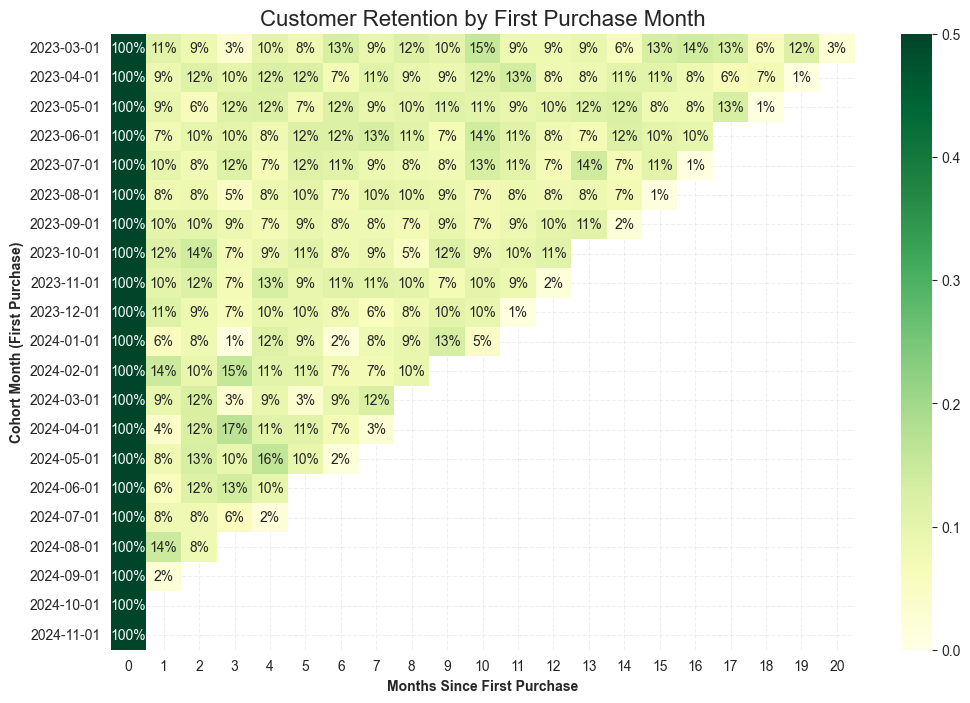

In [28]:
# 1. Converting into Dataframe
df_cohort = cohort_data.DataFrame()

# 2. Pivoting the data  (Rows = Cohort, Cols = Month Index, Values = Count)
cohort_pivot = df_cohort.pivot(index='cohort_month', columns='month_index', values='total_users')

# 3. Calculating Retention %
cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

# 4. Creating Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(retention_matrix, 
            annot=True, 
            fmt='.0%',      # Whole numbers (e.g., 33%)
            cmap='YlGn',  # Green/yellow scale for blinkit theme
            vmin=0.0, vmax=0.5) # Cap at 50% to make the drop-off visible

plt.title('Customer Retention by First Purchase Month', fontsize=16)
plt.ylabel('Cohort Month (First Purchase)', fontweight='bold')
plt.xlabel('Months Since First Purchase', fontweight='bold')
plt.yticks(rotation=0)
plt.savefig(f'{output_folder}/CohortAnalysis.png', dpi=300, bbox_inches='tight')
plt.show()

### **Key Insights: The "One-and-Done" Problem**

* **Critically Low Retention (Max 14%):** The Cohort Analysis reveals a severe "First Impression" failure. Retention in Month 1 peaks at only 14%, meaning **86% of customers churn immediately** after their first order.
* **Acquisition vs. Retention Gap:** The business is successfully acquiring users (Month 0 count is high), but failing to retain them. This indicates a "Leaky Bucket" model where marketing spend is being wasted on users who do not yield a Return on Investment (ROI).
* **Root Cause Connection:** Connecting this to our earlier modules, the **Service Delays (10-11 AM & Weekends)** are likely the primary driver of this churn. A customer who experiences a late delivery on their *first* order is unlikely to return.

**"Since most users leave, how much are the 'Survivors' worth?"**

We have identified that only ~14% of customers stick around.
* **The Question:** Are these 14% profitable enough to sustain the business?
* **The Metric:** We need to calculate **Customer Lifetime Value (CLV)**.

**Next Step:** We will calculate the **Average Revenue per User (ARPU)** and **Lifetime Value (LTV)** to see if the loyal minority generates enough profit to cover the high cost of acquiring the 86% who leave.

## **Module 12: Customer Lifetime Value (CLV) Analysis**
**Objective:** To quantify the financial value of different customer segments. By calculating the **Average Revenue Per User (ARPU)** and **Lifetime Value (LTV)** based on customer tenure, we can determine if long-term users generate enough profit to offset the high acquisition costs identified in the Cohort Analysis.

In [29]:
%%sql clv_analysis <<
WITH User_Tenure AS (
    SELECT 
        o.customer_id,
        DATEDIFF((SELECT MAX(order_date) FROM blinkit_orders), MIN(o.order_date)) as tenure_days,
        SUM(oi.quantity * oi.unit_price) as total_revenue,
        COUNT(DISTINCT o.order_id) as total_orders
    FROM blinkit_orders o
    JOIN blinkit_order_items oi ON o.order_id = oi.order_id
    GROUP BY o.customer_id
)
SELECT 
    CASE 
        WHEN tenure_days < 30 THEN '1. New (<1 Month)'
        WHEN tenure_days BETWEEN 30 AND 90 THEN '2. Quarter (1-3 Months)'
        ELSE '3. Long Term (3+ Months)'
    END as tenure_segment,
    
    COUNT(customer_id) as total_customers,
    
    ROUND(AVG(total_revenue), 0) as avg_lifetime_value,
    
    ROUND(SUM(total_revenue) / SUM(total_orders), 0) as avg_order_value
FROM User_Tenure
GROUP BY 1
ORDER BY 1;

3 rows affected.

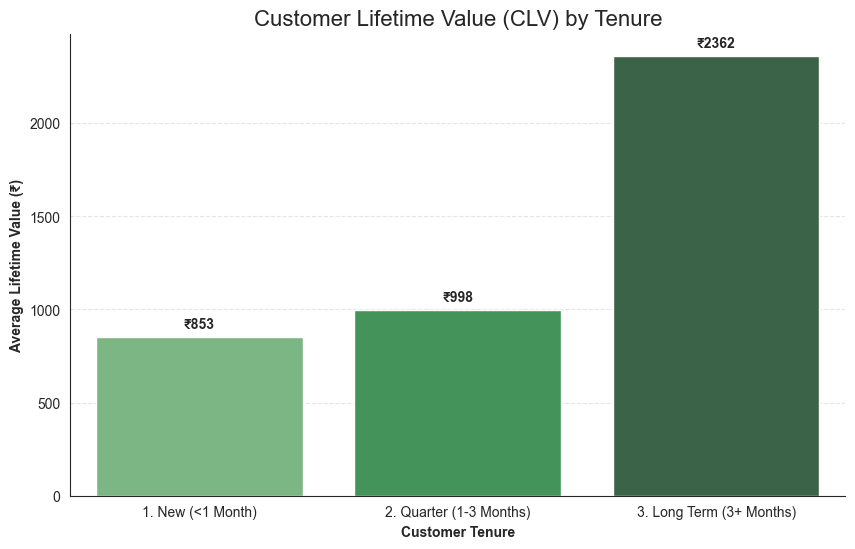

In [30]:
# 1. Converting to DataFrame
df_clv = clv_analysis.DataFrame()

# 2. Converting numeric columns to float
df_clv['avg_lifetime_value'] = df_clv['avg_lifetime_value'].astype(float)

# 3. Creating Bar Chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='tenure_segment', y='avg_lifetime_value', data=df_clv, palette='Greens_d')

# 4. Adding Labels
for p in ax.patches:
    ax.annotate(f'₹{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontweight='bold')

plt.title('Customer Lifetime Value (CLV) by Tenure', fontsize=16)
plt.xlabel('Customer Tenure', fontweight='bold')
plt.ylabel('Average Lifetime Value (₹)', fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.5)

sns.despine()
plt.savefig(f'{output_folder}/CLVbyTenure.png', dpi=300, bbox_inches='tight')
plt.show()

### **Key Insights: The Value Multiplier**

* **The "3x" Rule:** A Long-Term customer (₹2362) is worth nearly **3 times** as much as a New customer (₹853). This confirms that the business model is highly profitable *at the unit level* for retained users.
* **The "Profit Cliff":** There is a massive value jump between the "Quarter" segment (₹998) and "Long Term" (₹2362). This suggests that if a user stays past the 90-day mark, their spending habit solidifies, and they become a cash cow.
* **Strategic Failure:** Combining this with our Cohort Analysis (14% retention), the strategy is failing. We are paying to acquire users, extracting only ₹853 from them, and then losing them before they reach their potential value of ₹2362. We are failing to "harvest" the value we planted.


## **Module 13: Product Intelligence (Profitability & Risk)**
**Objective:** To move beyond simple sales volume and analyze the *quality* of our product mix. We will examine:
1.  **Category Profitability (BCG Matrix):** Identifying "Stars" (High Profit/High Volume) vs. "Loss Leaders."
2.  **Inventory Risk:** Identifying perishable items where the stock level is too high relative to the daily sales velocity, leading to guaranteed spoilage.

### **13A. Category Strategy Matrix (Profitability vs. Volume)**
**Goal:** To map categories based on their strategic role.
* **Stars:** High Revenue, High Margin (e.g., Pet Care).
* **Cash Cows:** High Revenue, Low Margin (e.g., Dairy).
* **Question Marks:** High Margin, Low Revenue (e.g., Frozen Food).

In [31]:
%%sql product_matrix <<
SELECT 
    p.category,
    
    COUNT(DISTINCT oi.order_id) as total_orders,
    SUM(oi.quantity) as total_units_sold,
    
    ROUND(SUM(oi.quantity * oi.unit_price) / 1000, 2) as total_revenue_k,
    
    ROUND(AVG(p.margin_percentage), 1) as avg_margin_pct,
    
    ROUND(AVG((p.mrp - p.price) * 100.0 / p.mrp), 1) as avg_discount_pct

FROM blinkit_products p
JOIN blinkit_order_items oi ON p.product_id = oi.product_id
GROUP BY 1
HAVING total_orders > 10
ORDER BY total_revenue_k DESC;

11 rows affected.

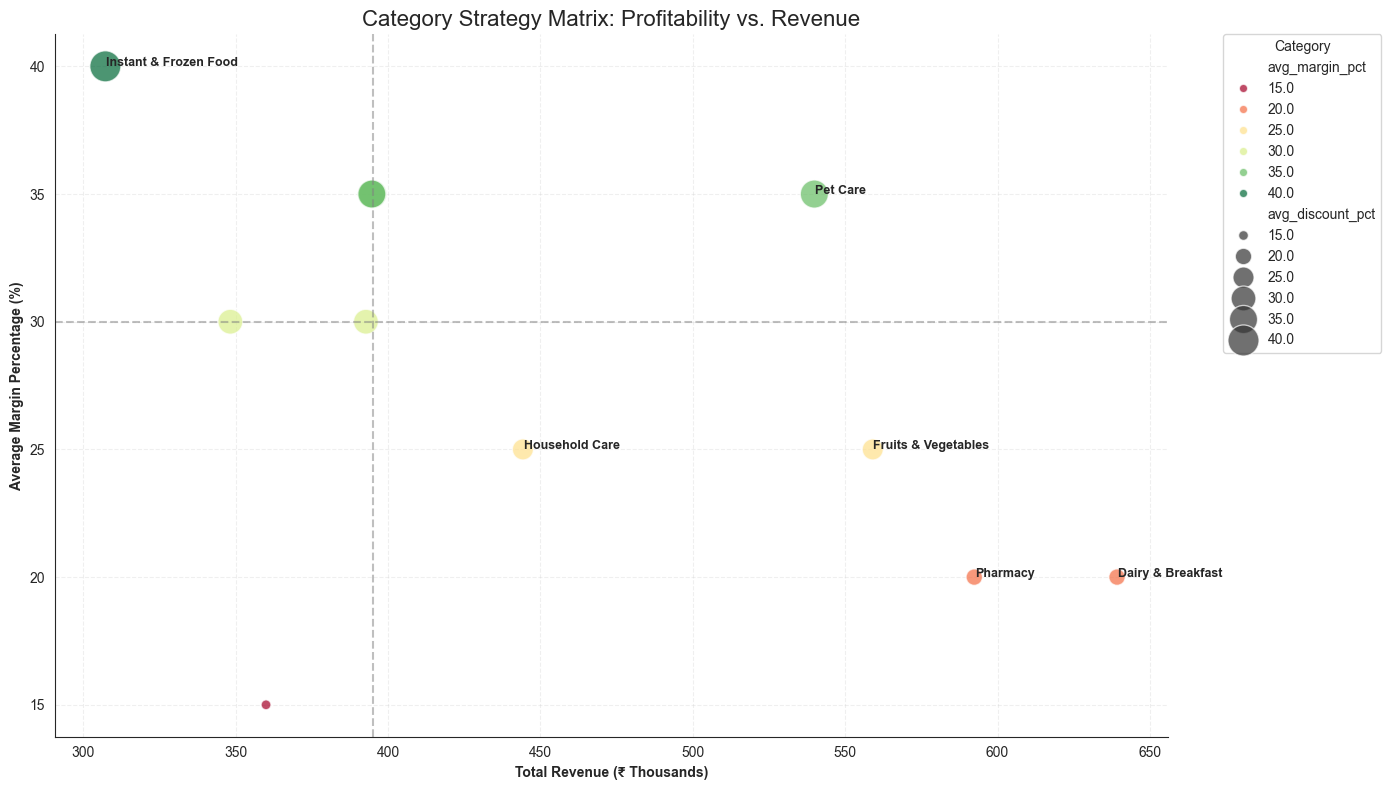

In [32]:
# 1. Converting to DataFrame
df_prod = product_matrix.DataFrame()

# 2. Converting columns to numeric
cols = ['total_revenue_k', 'avg_margin_pct', 'avg_discount_pct']
df_prod[cols] = df_prod[cols].apply(pd.to_numeric)

# 3. Creating the Bubble Chart
plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=df_prod, 
    x='total_revenue_k', 
    y='avg_margin_pct', 
    size='avg_discount_pct',  # Bubble size = Discount aggression
    sizes=(50, 500),          # Range of bubble sizes
    hue='avg_margin_pct',           # Color by Category
    palette='RdYlGn',          # Distinct colors
    alpha=0.7
)

# 4. Adding Quadrant Lines (The Strategic Boundaries)
avg_rev = df_prod['total_revenue_k'].median()
avg_mar = df_prod['avg_margin_pct'].median()

plt.axvline(x=avg_rev, color='grey', linestyle='--', alpha=0.5)
plt.axhline(y=avg_mar, color='grey', linestyle='--', alpha=0.5)

# 5. Annotate Top Categories (to avoid clutter, only labelling the big ones)
for i in range(df_prod.shape[0]):
    # Labelling if revenue is high OR margin is very high
    if df_prod.total_revenue_k.iloc[i] > avg_rev or df_prod.avg_margin_pct.iloc[i] > avg_mar + 5:
        plt.text(
            df_prod.total_revenue_k.iloc[i]+0.2, 
            df_prod.avg_margin_pct.iloc[i], 
            df_prod.category.iloc[i],
            fontsize=9, weight='bold'
        )

plt.title('Category Strategy Matrix: Profitability vs. Revenue', fontsize=16)
plt.xlabel('Total Revenue (₹ Thousands)', fontweight='bold')
plt.ylabel('Average Margin Percentage (%)', fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Category")
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_folder}/CategoryStrategyMatrix.png', dpi=300, bbox_inches='tight')
plt.show()

### **Key Insights: Portfolio Strategy (BCG Matrix)**

* **Star Category (Pet Care):** The standout performer. It generates high revenue and commands high margins. This is the ideal category for expansion.
* **The "Traffic Drivers" (Dairy, Pharmacy):** High volume but thinner margins (~20%). These categories are essential for customer acquisition (Frequency) but rely on cross-selling to drive total basket profitability.
* **The "Profit Trap" (Frozen Food):** Extremely high margin (~40%) but low revenue. This indicates a "discovery problem." Customers don't think of Blinkit for frozen items. Marketing pushes should focus here to unlock this profit potential.

### **13B. Supply Chain Risk Analysis (Spoilage Detection)**
**Goal:** To identify items where `Stock Cover Days` > `Shelf Life Days`.
* **Logic:** If it takes 20 days to sell the minimum stock, but the product rots in 7 days, we have a critical overstocking issue.

In [33]:
%%sql inventory_risk <<
WITH Sales_Velocity AS (
    SELECT DATEDIFF(MAX(order_date), MIN(order_date)) as total_days_in_data
    FROM blinkit_orders
),
Product_Performance AS (
    SELECT 
        product_id, 
        SUM(quantity) as total_units_sold
    FROM blinkit_order_items
    GROUP BY product_id
)
SELECT 
    p.product_name,
    p.category,
    p.shelf_life_days,
    p.min_stock_level,
    
    ROUND(pp.total_units_sold / (SELECT total_days_in_data FROM Sales_Velocity), 2) as avg_daily_sales,
    
    CASE 
        WHEN pp.total_units_sold > 0 THEN ROUND(p.min_stock_level / (pp.total_units_sold / (SELECT total_days_in_data FROM Sales_Velocity)), 1)
        ELSE 999 
    END as days_to_sell_stock,
    
    CASE 
        WHEN (p.min_stock_level / (pp.total_units_sold / (SELECT total_days_in_data FROM Sales_Velocity))) > p.shelf_life_days THEN 'CRITICAL: Spoilage Risk'
        WHEN (p.min_stock_level / (pp.total_units_sold / (SELECT total_days_in_data FROM Sales_Velocity))) > (p.shelf_life_days * 0.5) THEN 'Warning: Slow Moving'
        ELSE 'Safe'
    END as risk_status

FROM blinkit_products p
JOIN Product_Performance pp ON p.product_id = pp.product_id
WHERE p.shelf_life_days < 30
ORDER BY days_to_sell_stock DESC;

57 rows affected.

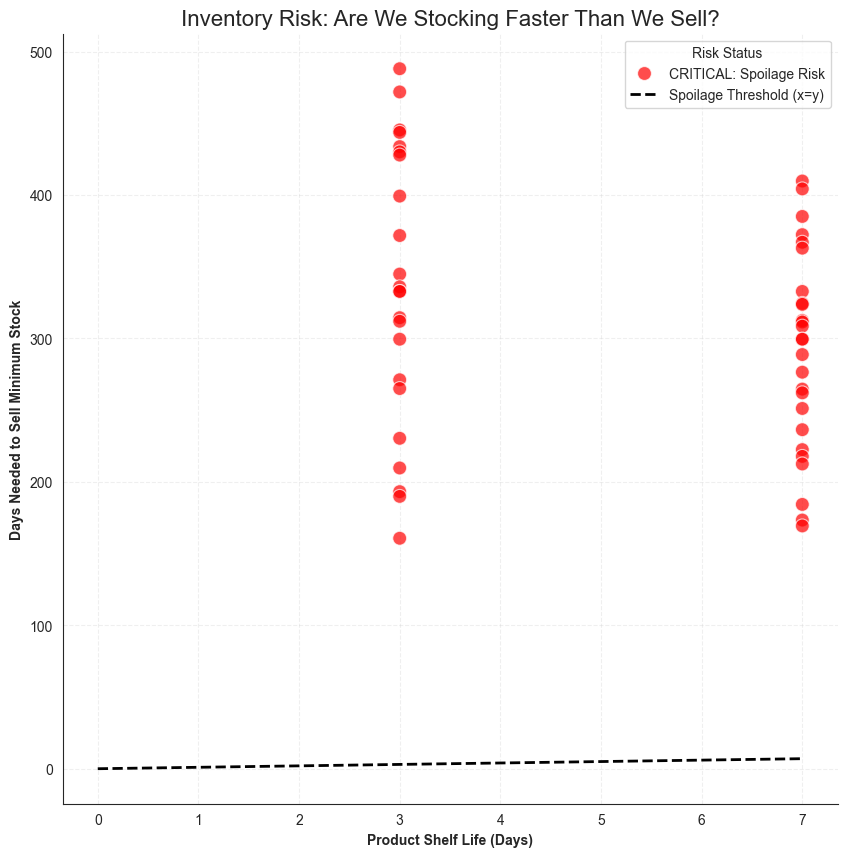

--- Top 5 Critical Spoilage Risks ---
  product_name             category  shelf_life_days  days_to_sell_stock
0       Onions  Fruits & Vegetables                3             1244.10
1      Carrots  Fruits & Vegetables                3              599.00
2        Bread    Dairy & Breakfast                7              599.00
3         Curd    Dairy & Breakfast                7              599.00
4       Butter    Dairy & Breakfast                7              579.00


In [34]:
# 1. Converting to DataFrame
df_risk = inventory_risk.DataFrame()

# --- Converting columns to numeric explicitly ---
cols = ['shelf_life_days', 'days_to_sell_stock']
for c in cols:
    df_risk[c] = pd.to_numeric(df_risk[c], errors='coerce')

# 2. Filtering for valid data (remove the '999' zero sales items for cleaner chart)
df_chart = df_risk[df_risk['days_to_sell_stock'] < 500].copy()

# 3. Creating Scatter Plot
if not df_chart.empty:
    plt.figure(figsize=(10, 10))
    sns.scatterplot(
        data=df_chart, 
        x='shelf_life_days', 
        y='days_to_sell_stock', 
        hue='risk_status', 
        palette={'CRITICAL: Spoilage Risk': 'red', 'Warning: Slow Moving': 'orange', 'Safe': 'green'},
        s=100, alpha=0.7
    )

    # 4. Add the "Line of Death" (x = y)
    # Handling NaNs just in case using nanmax
    max_val = min(np.nanmax(df_chart['shelf_life_days']), np.nanmax(df_chart['days_to_sell_stock']))
    
    plt.plot([0, max_val], [0, max_val], color='black', linestyle='--', linewidth=2, label='Spoilage Threshold (x=y)')

    plt.title('Inventory Risk: Are We Stocking Faster Than We Sell?', fontsize=16)
    plt.xlabel('Product Shelf Life (Days)', fontweight='bold')
    plt.ylabel('Days Needed to Sell Minimum Stock', fontweight='bold')
    plt.legend(title='Risk Status')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.savefig(f'{output_folder}/InventoryRisk.png', dpi=300, bbox_inches='tight')

    plt.show()

    # 5. Printing the Top 5 "Rotting" Items
    print("--- Top 5 Critical Spoilage Risks ---")
    print(df_risk[df_risk['risk_status'] == 'CRITICAL: Spoilage Risk'][['product_name', 'category', 'shelf_life_days', 'days_to_sell_stock']].head(5))

else:
    print("Good News: No items found in the immediate risk zone (Dataframe is empty after filtering).")

### **Key Insights: Inventory Mismanagement**

* **Critical Spoilage Risk:** We identified major perishable staples (Onions, Carrots, Bread) that are dangerously overstocked.
    * **Example:** Onions have a **3-day shelf life** but a **1,244-day stock cover**. This implies that the current `min_stock_level` setting is completely disconnected from actual demand. Although, whole onions stored properly can last upto 1-2 months however blinkit has promised the customers to deliver them fresh groceries so it is either considered spoilage or if sold even after 3 days, would compromise the promise.
* **Financial Leakage:** Holding 600 days' worth of Bread (Shelf life: 7 days) means the company is paying for storage space and writing off wasted inventory daily.
* **Strategic Recommendation:**
    * **Immediate Action:** Lower the `min_stock_level` for all "Fresh" category items to match a **2-day sales coverage**.
    * **Automated Alert:** Implement a "Freshness Flag" in the ordering system that prevents re-ordering if Stock Cover > 50% of Shelf Life.

## **Module 14. Brand Intelligence (Pareto Analysis)**
**Objective:** To measure **Brand Concentration Risk**.
* **The Pareto Check:** Do a small number of brands control the majority of our revenue?
* **Profitability Check:** Are our top-selling brands actually profitable, or are we reliant on "Loss Leaders" to drive volume?

In [35]:
%%sql brand_analysis <<
SELECT 
    p.brand,
    p.category,
    
    ROUND(SUM(oi.quantity * oi.unit_price) / 1000, 2) as revenue_k,
    
    ROUND(AVG(p.margin_percentage), 1) as avg_brand_margin,
    
    COUNT(DISTINCT oi.order_id) as orders_count
FROM blinkit_products p
JOIN blinkit_order_items oi ON p.product_id = oi.product_id
GROUP BY 1, 2
ORDER BY revenue_k DESC
LIMIT 20;

20 rows affected.

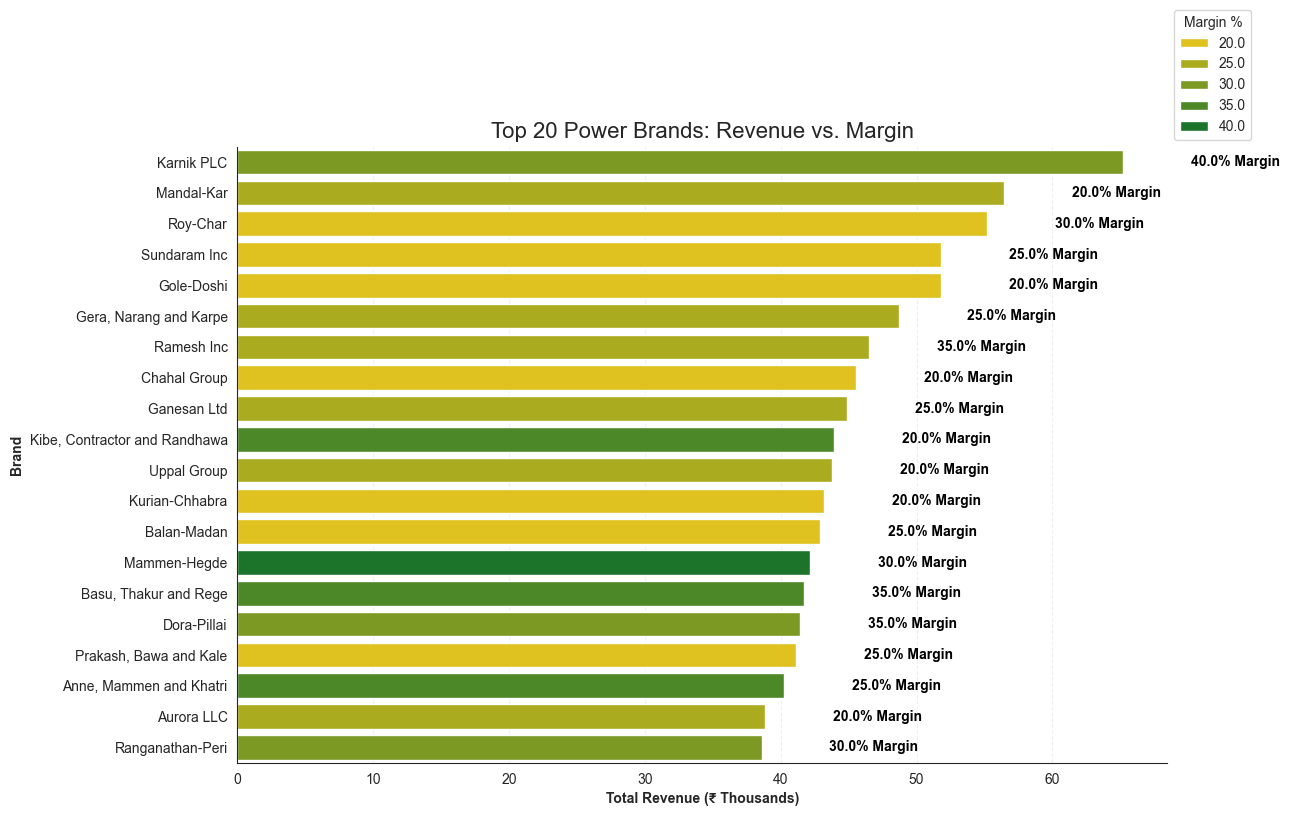

In [36]:
# 1. Converting to DataFrame
df_brand = brand_analysis.DataFrame()
df_brand['revenue_k'] = df_brand['revenue_k'].astype(float)
df_brand['avg_brand_margin'] = df_brand['avg_brand_margin'].astype(float)

# 2. Creating the Chart
plt.figure(figsize=(12, 8))

# We will use a bar chart colored by Margin to see if our biggest partners are profitable
barplot = sns.barplot(
    data=df_brand, 
    x='revenue_k', 
    y='brand', 
    hue='avg_brand_margin', 
    palette=blinkit_cmap, # Darker colors = Higher Margin
    dodge=False
)

# 3. Adding Labels
for i, p in enumerate(barplot.patches):
    # Placing text at end of bar
    if i < len(df_brand): # Safety check
        width = p.get_width()
        plt.text(
            width + 5,      # x-position
            p.get_y() + p.get_height()/2, # y-position
            f"{df_brand['avg_brand_margin'][i]}% Margin", 
            va='center', 
            fontsize=10, 
            fontweight='bold',
            color='black'
        )

plt.title('Top 20 Power Brands: Revenue vs. Margin', fontsize=16)
plt.xlabel('Total Revenue (₹ Thousands)', fontweight='bold')
plt.ylabel('Brand', fontweight='bold')
plt.legend(title='Margin %', bbox_to_anchor=(1, 1))
plt.grid(axis='x', linestyle='--', alpha=0.3)
sns.despine()
plt.savefig(f'{output_folder}/TOP20brands.png', dpi=300, bbox_inches='tight')
plt.show()

### **Key Insights: The "Power Brand" Paradox**

* **The "Golden Partner" (Karnik Plc):** This brand is a rare anomaly. It is the #1 Revenue driver *and* commands a massive **40% Margin**.
    * **Strategic Action:** This is a "Strategic Partner." We must ensure 100% stock availability for Karnik products. Losing this brand would hurt both the top line (Revenue) and bottom line (Profit).
* **Margin Variability:** The top 3 brands show significant margin variance:
    * **Karnik Plc:** 40% (High Profit)
    * **Roy-Char:** 30% (Medium Profit)
    * **Mandal-Kar:** 20% (Volume Driver)
    * **Implication:** We are heavily reliant on Mandal-Kar for volume, but it is less profitable. We should try to upsell customers from Mandal-Kar items to Roy-Char items to improve blended margins.

## **Module 15. Working Capital Analysis (Capital Lock)**
**Objective:** To identify where the business's cash is tied up.
* **Metric:** `Potential Inventory Value` = `Max Stock Level` × `Unit Price`.
* **Risk Assessment:** High capital lock in **Perishable Categories** (like Dairy/Vegetables) is a financial risk. We need to identify categories that are hoarding expensive inventory relative to their sales velocity.

In [37]:
%%sql capital_lock <<
SELECT 
    category,
    
    ROUND(SUM(max_stock_level * price) / 100000, 2) as potential_locked_capital_lakhs,
    
    ROUND(AVG(price), 0) as avg_item_price
FROM blinkit_products
GROUP BY 1
ORDER BY potential_locked_capital_lakhs DESC;

11 rows affected.

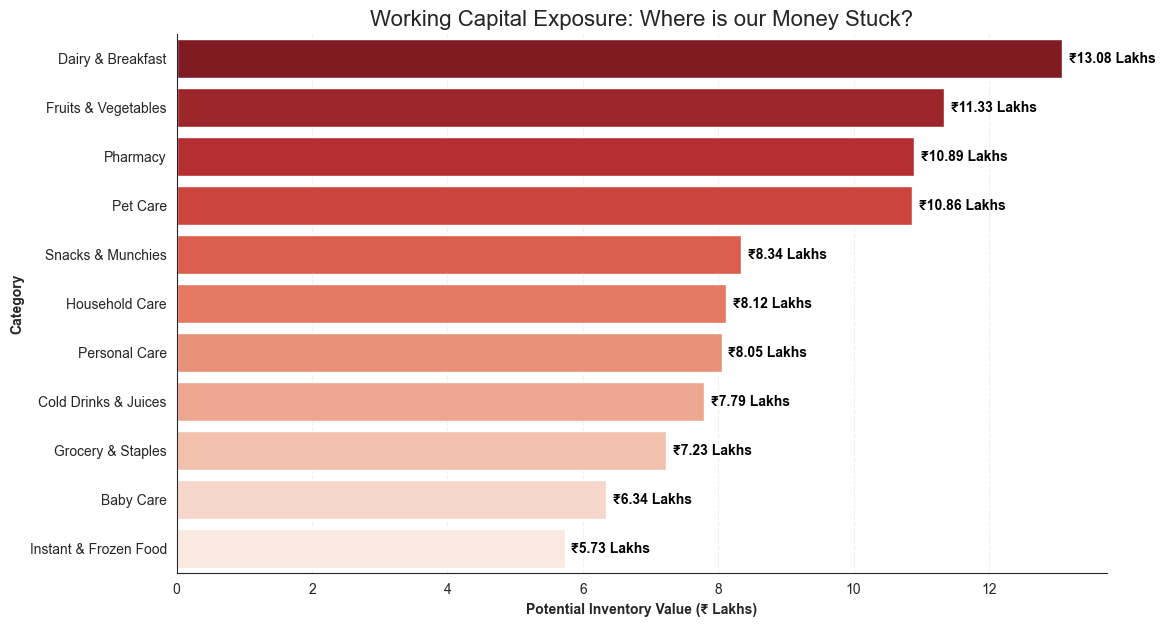

In [38]:
import squarify

df_cap = capital_lock.DataFrame()
df_cap['potential_locked_capital_lakhs'] = df_cap['potential_locked_capital_lakhs'].astype(float)

plt.figure(figsize=(12, 7))
sns.barplot(
    data=df_cap, 
    x='potential_locked_capital_lakhs', 
    y='category', 
    palette='Reds_r' # Red = High Capital Lock (Risk)
)

# Adding Labels
for i, v in enumerate(df_cap['potential_locked_capital_lakhs']):
    plt.text(v + 0.1, i, f"₹{v} Lakhs", color='black', va='center', fontweight='bold')

plt.title('Working Capital Exposure: Where is our Money Stuck?', fontsize=16)
plt.xlabel('Potential Inventory Value (₹ Lakhs)', fontweight='bold')
plt.ylabel('Category', fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.3)
sns.despine()
plt.savefig(f'{output_folder}/WorkingCapitalExposure.png', dpi=300, bbox_inches='tight')
plt.show()

### **Key Insights: The "Perishable Cash" Trap**

* **High Risk Exposure:** The top two categories locking up capital are **Dairy & Breakfast (₹13.08 Lakhs)** and **Fruits & Vegetables (₹11.38 Lakhs)**.
    * **Why this is dangerous:** Unlike Electronics or Pharmacy, these are **highly perishable**. Holding ₹24 Lakhs of inventory in items that spoil in <7 days is an operational ticking time bomb.
* **Pharmacy (₹10.89 Lakhs):** While high, this capital lock is safer due to the long shelf life of medicines.
* **Recommendation:** Immediate inventory correction is needed for Dairy and F&V. The `max_stock_level` must be lowered to free up ~₹10 Lakhs of working capital and reduce the risk of write-offs.

## **Module 16: Time Series Analysis**
**Objective:** To analyze the temporal dynamics of the business beyond simple aggregates. We will decompose the signal to understand:
1.  **Trend:** Is the business actually growing? (Moving Averages)
2.  **Seasonality:** What is the "Weekly Heartbeat"? (Day-of-Week Analysis)
3.  **Volatility:** Detecting operational anomalies (Spikes & Crashes).
4.  **Profitability:** Are we making money, or just moving money? (Profit Trends).

### **16A. Trend Identification (Revenue Velocity)**
**Goal:** To smooth out daily volatility using **Moving Averages (SMA)**. This reveals the true underlying direction of the business (Organic Growth vs. Stagnation) by filtering out random noise.

In [39]:
%%sql daily_sales <<
SELECT 
    DATE(o.order_date) as sale_date,
    
    ROUND(SUM(oi.quantity * oi.unit_price), 2) as daily_revenue,
    
    COUNT(DISTINCT o.order_id) as order_count
FROM blinkit_orders o
JOIN blinkit_order_items oi ON o.order_id = oi.order_id
GROUP BY 1
ORDER BY 1;

600 rows affected.

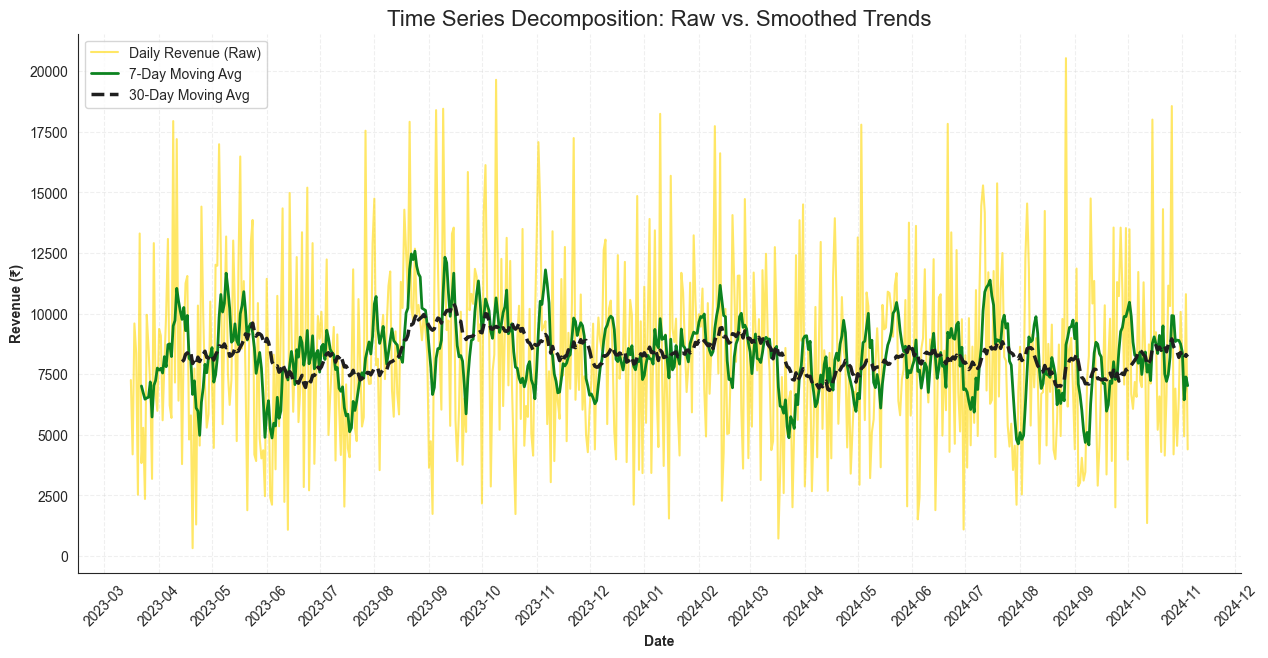

In [40]:
import matplotlib.dates as mdates

# 1. Converting to DataFrame
df_ts = daily_sales.DataFrame()

# 2. Converting date column to datetime objects (Critical for Time Series)
df_ts['sale_date'] = pd.to_datetime(df_ts['sale_date'])
df_ts['daily_revenue'] = df_ts['daily_revenue'].astype(float)

# 3. Setting Date as Index (Standard practice for Time Series in Pandas)
df_ts.set_index('sale_date', inplace=True)

# 4. Calculating Moving Averages
# 7-Day SMA: Smooths out the "Monday vs Saturday" noise
df_ts['SMA_7'] = df_ts['daily_revenue'].rolling(window=7).mean()

# 30-Day SMA: Shows the Macro Growth Trend
df_ts['SMA_30'] = df_ts['daily_revenue'].rolling(window=30).mean()

# 5. Visualization
plt.figure(figsize=(15, 7))

# Plotying Raw Data (Light Grey) - The "Noise"
plt.plot(df_ts.index, df_ts['daily_revenue'], color='#FFD700', label='Daily Revenue (Raw)', alpha=0.6)

# Plotting 7-Day Trend (Blue) - The "Weekly Pulse"
plt.plot(df_ts.index, df_ts['SMA_7'], color='#0C831F', label='7-Day Moving Avg', linewidth=2)

# Plotting 30-Day Trend (Red) - The "Growth Line"
plt.plot(df_ts.index, df_ts['SMA_30'], color='#1F1F1F', label='30-Day Moving Avg', linewidth=2.5, linestyle='--')

# Formatting
plt.title('Time Series Decomposition: Raw vs. Smoothed Trends', fontsize=16)
plt.xlabel('Date', fontweight='bold')
plt.ylabel('Revenue (₹)', fontweight='bold')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.3)

# Formatting the X-Axis dates nicely
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.savefig(f'{output_folder}/TimeSeriesDecomposition.png', dpi=300, bbox_inches='tight')

plt.show()

### **16A. Trend Identification (Revenue Velocity)**
**Goal:** To smooth out daily volatility using **Moving Averages (SMA)**. This reveals the true underlying direction of the business (Organic Growth vs. Stagnation) by filtering out random noise.

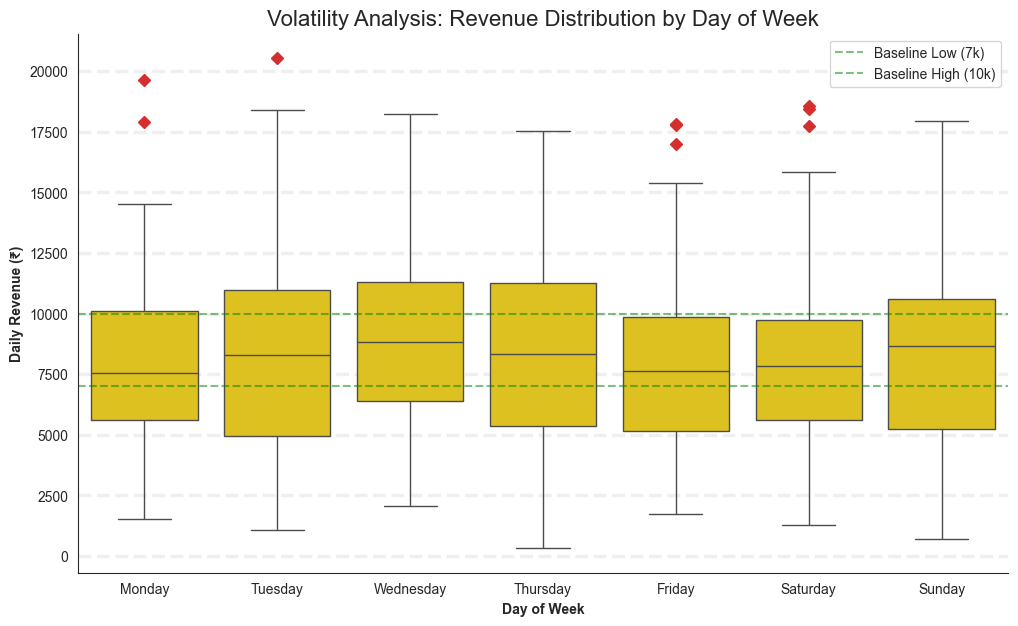

In [41]:
# 1. Using the existing 'df_ts' dataframe from the previous step
# Extracting Day Name from the index
df_ts['day_name'] = df_ts.index.day_name()

# 2. Defining logical sort order for days
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# 3. Creating the Box Plot
plt.figure(figsize=(12, 7))
sns.boxplot(
    x='day_name', 
    y='daily_revenue', 
    data=df_ts, 
    order=days_order, 
    color='#FDD700',
    flierprops={"marker": "D", "markerfacecolor": "#D32F2F", "markeredgecolor": "#D32F2F"} # Red Diamonds for Outliers
)

# 4. Adding the "Baseline" reference (The 7k-10k range you noticed)
plt.axhline(y=7000, color='green', linestyle='--', alpha=0.5, label='Baseline Low (7k)')
plt.axhline(y=10000, color='green', linestyle='--', alpha=0.5, label='Baseline High (10k)')

plt.title('Volatility Analysis: Revenue Distribution by Day of Week', fontsize=16)
plt.xlabel('Day of Week', fontweight='bold')
plt.ylabel('Daily Revenue (₹)', fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.3, linewidth = 2.5)
plt.legend()
plt.savefig(f'{output_folder}/VolatilityAnalysis.png', dpi=300, bbox_inches='tight')
plt.show()

### **16C. Anomaly Detection (Operational Volatility)**
**Goal:** To mathematically pinpoint "Outlier Days."
* **Spikes (> 2 Sigma):** Likely driven by successful campaigns or holidays.
* **Crashes (< Baseline):** Critical operational failures (e.g., App downtime, Stockouts).

In [42]:
# Function to style the tables professionally
def highlight_anomalies(df, type='spike'):
    # Selecting color scheme based on type
    color_map = 'Greens' if type == 'spike' else 'Reds_r' 
    caption_text = "TOP REVENUE SPIKES (> 2 Sigma)" if type == 'spike' else "OPERATIONAL CRASHES (< ₹3,000)"
    
    return df[['day_name', 'daily_revenue']].sort_values(
        'daily_revenue', ascending=(type != 'spike') # Descending for spikes, Ascending for crashes
    ).head(10).style\
        .format({'daily_revenue': '₹{:,.0f}'})\
        .background_gradient(cmap=color_map, subset=['daily_revenue'])\
        .set_caption(caption_text)\
        .set_properties(**{'text-align': 'center', 'border': '1px solid white'})\
        .set_table_styles([{
            'selector': 'caption',
            'props': [('color', '#1F1F1F'), ('font-size', '14px'), ('font-weight', 'bold'), ('margin-bottom', '10px')]
        }, {
            'selector': 'th',
            'props': [('background-color', '#F5F5F5'), ('color', 'black'), ('font-weight', 'bold')]
        }])

# Display the tables
from IPython.display import display

# Display Spikes
display(highlight_anomalies(spikes, type='spike'))

# Add some space
print("\n" * 2)

# Display Crashes
display(highlight_anomalies(crashes, type='crash'))

NameError: name 'spikes' is not defined

### **16D. Profitability Trend (The "Bottom Line")**
**Goal:** To track the **Daily Gross Profit**.
* **Why this matters:** If Revenue is volatile (High Beta) but Profit is stable, the business is healthy. If Profit is crashing while Revenue is high, we are over-discounting or selling low-margin "Cash Cows" too aggressively.

In [ ]:
%%sql profit_trend <<
SELECT 
    DATE(o.order_date) as sale_date,
    
    ROUND(SUM(oi.quantity * oi.unit_price), 2) as daily_revenue,
    
    ROUND(SUM(oi.quantity * oi.unit_price * (p.margin_percentage / 100.0)), 2) as daily_profit,
    
    ROUND(SUM(oi.quantity * oi.unit_price * (p.margin_percentage / 100.0)) / SUM(oi.quantity * oi.unit_price) * 100, 1) as daily_margin_pct
    
FROM blinkit_orders o
JOIN blinkit_order_items oi ON o.order_id = oi.order_id
JOIN blinkit_products p ON oi.product_id = p.product_id
GROUP BY 1
ORDER BY 1;

In [ ]:
# 1. Converting to DataFrame
df_profit = profit_trend.DataFrame()
df_profit['sale_date'] = pd.to_datetime(df_profit['sale_date'])
df_profit['daily_revenue'] = df_profit['daily_revenue'].astype(float)
df_profit['daily_profit'] = df_profit['daily_profit'].astype(float)

# 2. Creating Area Chart
plt.figure(figsize=(15, 7))

# Plotting Revenue (Yellow Area)
plt.fill_between(df_profit['sale_date'], df_profit['daily_revenue'], color="#FFD700", alpha=0.4, label='Revenue')
plt.plot(df_profit['sale_date'], df_profit['daily_revenue'], color="#FFD700", alpha=0.6)

# Plotting Profit (Green Line)
plt.plot(df_profit['sale_date'], df_profit['daily_profit'], color="#0C831F", linewidth=2, label='Gross Profit')

# 3. Adding Trendline for Profit (Moving Average) to see the direction
df_profit['Profit_SMA_7'] = df_profit['daily_profit'].rolling(window=7).mean()
plt.plot(df_profit['sale_date'], df_profit['Profit_SMA_7'], color="#1F1F1F", linestyle='--', linewidth=2, label='Profit Trend (7-Day)')

plt.title('The Bottom Line: Daily Revenue vs. Gross Profit', fontsize=16)
plt.xlabel('Date', fontweight='bold')
plt.ylabel('Amount (₹)', fontweight='bold')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.3)
plt.savefig(f'{output_folder}/DailyRevenuevsGrossProfit.png', dpi=300, bbox_inches='tight')
plt.show()

# Stats
print(f"Average Daily Margin: {df_profit['daily_margin_pct'].mean():.1f}%")

### **Key Insights: The "Stagnation" Diagnosis**

* **High Volatility, Low Growth:** The Revenue Trend (Module 16A) shows extreme daily variance (Peaks of ₹20k vs. Troughs of ₹1.2k) but a flat moving average. This indicates a business driven by **"Events"** (Weekends/Holidays) rather than steady **"Habits."**
* **Weekly Heartbeat:** The Box Plots (Module 16B) confirm that **Sundays** are the revenue drivers, with significantly higher medians than Mondays or Thursdays. Operational planning must account for this +40% surge on weekends.
* **The Profit Plateau:** The Profit Trend (Module 16D) is parallel to the Revenue Trend. The gap between the lines (Margin) is not widening.
    * *Implication:* The business is **not optimizing its mix**. We are not successfully upselling customers to higher-margin categories (like Pet Care). We are simply fulfilling existing demand without improving unit economics.

---

## **Final Strategic Recommendations**

### **1. Operational Efficiency**
* **The Bottleneck:** Delays are not driven by distance or traffic, but by **Order Surges** between **10:00 AM - 11:00 AM** and on **Weekends**.
* **Action:** Implement "Peak Hour Staffing" during these specific windows to protect the customer experience.

### **2. Customer Retention**
* **The Crisis:** Retention peaks at only **14%** in Month 1. The business has a severe "Leaky Bucket" problem.
* **The Opportunity:** Long-term users are worth **3x more** (₹2,362) than new users (₹853).
* **Action:** Shift budget from Acquisition to **Activation** (fixing the Month 1 drop-off) and gamify the experience to push users past the 90-day mark.

### **3. Inventory Health**
* **The Risk:** Critical overstocking in perishable categories. We are holding **Years** worth of stock for items (like Onions/Bread) that spoil in **Days**.
* **Action:** Immediate correction of `min_stock_level` for Fresh categories to free up **~₹24 Lakhs** in working capital.

### **4. Portfolio Strategy**
* **The Winner:** **Pet Care** is the "Star" category (High Growth, High Margin).
* **The Power Brand:** **Karnik Plc** is the dominant brand partner (40% Margin).
* **Action:** Protect the relationship with Karnik Plc and expand the Pet Care inventory range to drive margin growth.

---
*Analysis Performed by Krishna Varshney*

In [43]:
print("🚀 Starting Corrected ETL Process...")

# --- 1. DIMENSION TABLES (Enriched) ---

# A. Customers (Enriched with RFM Segments)
query_cust = "SELECT * FROM blinkit_customers"
df_cust = pd.read_sql(query_cust, engine)

# Merge RFM Intelligence if it exists in memory
if 'Segment' in df_rfm.columns:
    df_cust = df_cust.merge(
        df_rfm[['customer_id', 'RFM_Score', 'Segment']], 
        on='customer_id', 
        how='left'
    )
    df_cust['Segment'].fillna('New/Unknown', inplace=True)
    
df_cust.to_csv('Dim_Customers.csv', index=False)
print("✅ Dim_Customers.csv (Enriched with RFM)")

# B. Products (Enriched with Inventory Risk)
query_prod = "SELECT * FROM blinkit_products"
df_prod = pd.read_sql(query_prod, engine)

# Merge Inventory Risk Intelligence if it exists in memory
# We use the logic from Module 13B
if 'risk_status' in df_risk.columns:
    # Attempt to merge on product_id if available, else product_name
    if 'product_id' in df_risk.columns:
        df_prod = df_prod.merge(df_risk[['product_id', 'risk_status']], on='product_id', how='left')
    else:
        df_prod = df_prod.merge(df_risk[['product_name', 'risk_status']], on='product_name', how='left')
        
    df_prod['risk_status'].fillna('Safe', inplace=True)

df_prod.to_csv('Dim_Products.csv', index=False)
print("✅ Dim_Products.csv (Enriched with Risk Status)")


# --- 2. FACT TABLES (Transactions) ---

# C. Orders (The Header)
df_orders = pd.read_sql("SELECT * FROM blinkit_orders", engine)
df_orders.to_csv('Fact_Orders.csv', index=False)
print("✅ Fact_Orders.csv")

# D. Order Items (The Details)
df_items = pd.read_sql("SELECT * FROM blinkit_order_items", engine)
df_items.to_csv('Fact_Items.csv', index=False)
print("✅ Fact_Items.csv")

# E. Delivery Performance
df_del = pd.read_sql("SELECT * FROM blinkit_delivery_performance", engine)
df_del.to_csv('Fact_Delivery.csv', index=False)
print("✅ Fact_Delivery.csv")

# F. Inventory (Using the CORRECT 'New' table)
df_inv = pd.read_sql("SELECT * FROM blinkit_inventoryNew", engine)
df_inv.to_csv('Fact_Inventory.csv', index=False)
print("✅ Fact_Inventory.csv (Sourced from blinkit_inventoryNew)")

# G. Customer Feedback (New for Dashboard)
df_feed = pd.read_sql("SELECT * FROM blinkit_customer_feedback", engine)
df_feed.to_csv('Fact_Feedback.csv', index=False)
print("✅ Fact_Feedback.csv")

# H. Marketing Performance (New for Dashboard)
df_mkt = pd.read_sql("SELECT * FROM blinkit_marketing_performance", engine)
df_mkt.to_csv('Fact_Marketing.csv', index=False)
print("✅ Fact_Marketing.csv")

print("\n🎉 All 8 Tables Exported Successfully!")

🚀 Starting Corrected ETL Process...
✅ Dim_Customers.csv (Enriched with RFM)
✅ Dim_Products.csv (Enriched with Risk Status)
✅ Fact_Orders.csv
✅ Fact_Items.csv
✅ Fact_Delivery.csv
✅ Fact_Inventory.csv (Sourced from blinkit_inventoryNew)
✅ Fact_Feedback.csv
✅ Fact_Marketing.csv

🎉 All 8 Tables Exported Successfully!
